In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import brentq
from scipy.interpolate import griddata
import os
import seaborn as sns

sns.set_style('whitegrid')
cls = ['#17707B','#70A551','#F9B859','#F6926A','#80173A', '#000000']

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica", "sans-serif"],
    "mathtext.fontset": "dejavusans",
    'font.size': 16,
    'image.cmap': 'YlGnBu',
})

POT = {}
bkg = {}

# POT used in MC simulation
POT['ND280+_MC'] = 2.6098758621e22
POT['ND280_MC'] = 3.6e21

# POT in Abe et al 2019
POT['ND280_nu_2019'] = 1.234e21
POT['ND280_nubar_2019'] = 6.29e20

POT['ND280_nu_2023'] = 19.7e20
POT['ND280_nubar_2023'] = 16.3e20

# POT Events conducted in ND280+
# 1E22 is cumulative
POT['ND280_nu_2019to2023'] = POT['ND280_nu_2023'] - POT['ND280_nu_2019']
POT['ND280_nubar_2019to2023'] = POT['ND280_nubar_2023'] - POT['ND280_nubar_2019']

POT['ND280+_nu'] = 1e22 - POT['ND280_nu_2023'] 
POT['ND280+_nubar'] = 1e22 - POT['ND280_nubar_2023']


# TPC e+e- background from Abe et al 2019
bkg['ND280_nu_2019'] = 0.563
bkg['ND280_nubar_2019'] = 0.015 

bkg['ND280+_nu'] = bkg['ND280_nu_2019'] * 5 / 3 * POT['ND280+_nu'] / POT['ND280_nu_2019'] 
bkg['ND280+_nubar'] = bkg['ND280_nubar_2019']* 5 / 3 * POT['ND280+_nubar'] / POT['ND280_nu_2019'] 

bkg['ND280_nu_2023'] = bkg['ND280_nu_2019'] * POT['ND280_nu_2023'] / POT['ND280_nu_2019'] 
bkg['ND280_nubar_2023'] = bkg['ND280_nubar_2019'] * POT['ND280_nubar_2023'] / POT['ND280_nu_2019'] 

bkg['ND280_nu_2019to2023'] = bkg['ND280_nu_2019'] * POT['ND280_nu_2019to2023'] / POT['ND280_nu_2019'] 
bkg['ND280_nubar_2019to2023'] = bkg['ND280_nubar_2019'] * POT['ND280_nubar_2019to2023'] / POT['ND280_nu_2019'] 


In [2]:
POT_weight = POT['ND280+_nu']/POT['ND280+_MC']
POT_weight_OG = POT['ND280_nu_2023']/POT['ND280_MC']


def BR(m):
    alpha = 1/137 # Fine structure constant
    me = 0.511e-3 # Electron mass in GeV
    r = me/m
    L = lambda r:(2 - r**6 * 0.125) * np.arccosh(1/r) - (24 - 10 * r**2 + r**4) * 0.125 * np.sqrt(1 - 4*r**2)
    return np.array(alpha * L(r) / (3 * np.pi))

def get_data_csv(scale='log', year=3, exp='ND280+', mode = 'nu', nobump=False, err=None):
    
    '''
    Scale = ['log' or 'linear']
    Year = 0, 1, 2, 3 only applies to ND280+ projection
    Mode = ['nu', 'nubar']
    '''
    
    if nobump:
        if exp == 'ND280+' and mode == 'nu':
            path='../stats/nobump+_.csv'
        elif exp in ['ND280','ND280_proj'] and mode == 'nu':
            path='../stats/nobump_.csv'
        elif exp == 'ND280+' and mode == 'nubar':
            path='../stats/nobump_bar+_.csv'
        elif exp in ['ND280','ND280_proj'] and mode == 'nubar':
            path='../stats/nobump_bar_.csv'
    
    elif err == 'up':
        if exp == 'ND280+' and mode == 'nu':
            path='../stats/STATS_NU+_ERRu.csv' 
        elif exp in ['ND280','ND280_proj'] and mode == 'nu':
            path='../stats/STATS_NU_ERRu.csv' 
        elif exp == 'ND280+' and mode == 'nubar':
            path='../stats/STATS_NUBAR+_ERRu.csv' 
        elif exp in ['ND280','ND280_proj'] and mode == 'nubar':
            path='../stats/STATS_NUBAR_ERRu.csv' 
            
    elif err == 'down':
        if exp == 'ND280+' and mode == 'nu':
            path='../stats/STATS_NU+_ERRd.csv' 
        elif exp in ['ND280','ND280_proj'] and mode == 'nu':
            path='../stats/STATS_NU_ERRd.csv' 
        elif exp == 'ND280+' and mode == 'nubar':
            path='../stats/STATS_NUBAR+_ERRd.csv' 
        elif exp in ['ND280','ND280_proj'] and mode == 'nubar':
            path='../stats/STATS_NUBAR_ERRd.csv' 
    
    elif err is None:
        if exp == 'ND280+' and mode == 'nu':
            path='../stats/STATS_NU+.csv' 
        elif exp in ['ND280','ND280_proj'] and mode == 'nu':
            path='../stats/STATS_NU.csv' 
        elif exp == 'ND280+' and mode == 'nubar':
            path='../stats/STATS_NUBAR+.csv' 
        elif exp in ['ND280','ND280_proj'] and mode == 'nubar':
            path='../stats/STATS_NUBAR.csv' 
        
    df = pd.read_csv(path).sort_values(['Experiment', 'i'])
    grouped = df.groupby('Experiment')
    
    signal_strengths = {exp: group.drop(['Experiment', 'i'], axis=1).to_numpy() 
                        for exp, group in grouped}
    
    last_exp = list(signal_strengths.keys())[-1]
    mass = signal_strengths[last_exp][:, 0]
    coupling = signal_strengths[last_exp][:, 1]
    
    total_signal_strengths = np.sum([arr[:, 2] for arr in signal_strengths.values()], axis=0)
    
    # Downweight by branching ratio
    total_signal_strengths *= BR(mass)
    
    # Scale by respective POT
    if exp == 'ND280+':
        if mode =='nu':
            ratio = POT['ND280+_nu']/POT['ND280+_MC'] * year / 3 
        else:
            ratio = POT['ND280+_nubar']/POT['ND280+_MC'] * year / 3

    elif exp == 'ND280':
        if mode =='nu':
            ratio = POT['ND280_nu_2019']/POT['ND280_MC']
        else:
            ratio = POT['ND280_nubar_2019']/POT['ND280_MC']
            
    elif exp == 'ND280_proj':
        if mode =='nu':
            ratio = POT['ND280_nu_2019to2023']/POT['ND280_MC']
        else:
            ratio = POT['ND280_nubar_2019to2023']/POT['ND280_MC']
            
    total_signal_strengths *= ratio
    
    # COUPLING/2 = TMM 
    if scale == 'log':
        return (np.log10(mass * 1000), np.log10(coupling / 2), np.log10(total_signal_strengths))
    return (np.log10(mass * 1000), np.log10(coupling / 2), total_signal_strengths)

signal_threshold = {}

def logLR(z, key='ND280+_nu', year=3):
    if key=='sfgd':
        return np.absolute(z - z * 99 * np.log(1 + 1/99))
    else:
        return np.absolute(z - (bkg[key]*year/3) * np.log(1 + z/bkg[key]*year/3))
    
def logTS_zero(z, key=None, year=None):
    return np.absolute(z)
    
# 95% Confidence Level
def tar(cl):
    return 0.5 * stats.norm.ppf(1-cl)**2

def signal_with_bkg(z,key='ND280+_nu',year=3):
    return z + bkg[key]*year/3

def poisson_target(cl):
    return np.abs(np.log(1-cl))

def obtain_fgd_signal():
    z,zb = [],[]
    with open(f'./sfgd_counts.txt','r') as r:
        for line in r.readlines():
            x, y, counts = line.strip().split()
            z.append(float(counts) * POT[f'ND280_nu_2023'])
        
    with open(f'./sfgd_counts_bar.txt','r') as r:
        for line in r.readlines():
            _, _, counts = line.strip().split()
            zb.append(float(counts) * POT[f'ND280_nubar_2023'])
    
    max_efficiency = 1.9/100 

    z = np.array(z) * max_efficiency 
    zb = np.array(zb) * max_efficiency

    return x, y, z, zb

Smooth out contour 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import zoom

def create_pixel_plot(x, y, z, tar, scale='log', save_str=None, zoom_factor=3, scatter=None):
    """
    Create a pixel plot with smoothed contours using scipy.ndimage.zoom
    
    Parameters:
    -----------
    x, y, z : numpy arrays
        Data points and values
    tar : float
        Target contour level
    scale : str
        'log' or 'linear' scale
    save_str : str or None
        If provided, save contour data to this filename
    zoom_factor : int
        Factor by which to zoom/smooth the data (higher = smoother)
    """
    # Apply log scaling if requested
    tar = np.log10(tar) if scale=='log' else tar
    z = np.log10(z) if scale=='log' else z
    
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]
    
    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)
    
    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)
    
    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi
    
    # Apply zoom/smoothing to the grid
    z_grid_smooth = zoom(z_grid, zoom_factor, order=1)  # order=3 for cubic interpolation
    
    # Create new coordinate arrays for the smoothed grid
    x_smooth = np.linspace(x_unique.min(), x_unique.max(), z_grid_smooth.shape[1])
    y_smooth = np.linspace(y_unique.min(), y_unique.max(), z_grid_smooth.shape[0])
    X_smooth, Y_smooth = np.meshgrid(x_smooth, y_smooth)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the smoothed image
    im = ax.imshow(z_grid_smooth, origin='lower', 
                  extent=[x_unique.min(), x_unique.max(), 
                         y_unique.min(), y_unique.max()],
                  aspect='auto')
    
    plt.colorbar(im, label='$log_{10}$ A.U.')
    ax.set_xlabel(r'$log_{10}(m/MeV)$', fontsize=16)
    ax.set_ylabel(r'$log_{10}(d_{\nu N})$', fontsize=16)
    
    # Create smoothed contour
    contour_line = plt.contour(X_smooth, Y_smooth, z_grid_smooth, 
                              levels=[tar], colors='white', 
                              linestyles='dashed', linewidths=2)
    
    # Save contour data if requested
    if save_str is not None:
        with open(f'{save_str}.txt', 'w') as f:
            # f.write(f"Contour Level: {tar}\n")
            for path in contour_line.allsegs[0]:
                for x, y in path:
                    f.write(f"{10**x:.32f}\t{10**y:.32f}\n")
                f.write("\n")
    if scatter is not None:
        n_m = 10
        n_mu = 10
        m_sample = np.geomspace(1e-2,2,n_m)
        mu_sample = np.geomspace(1e-7,1e-5,n_mu)
        m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
        m_sample = np.reshape(m_sample,[n_m*n_mu])
        mu_sample = np.reshape(mu_sample,[n_m*n_mu])
        
        plt.scatter(np.log10(m_sample[scatter]*1000),np.log10(mu_sample[scatter]/2), s=200, c='green')
        
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xscale('linear')
    plt.yscale('linear')
    plt.tight_layout()
    
    
    return fig, ax, contour_line


In [7]:
-np.log(0.05)

2.995732273553991

(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='$log_{10}(m/MeV)$', ylabel='$log_{10}(d_{\\nu N})$'>,
 <matplotlib.contour.QuadContourSet at 0x1470da7b6ed0>)

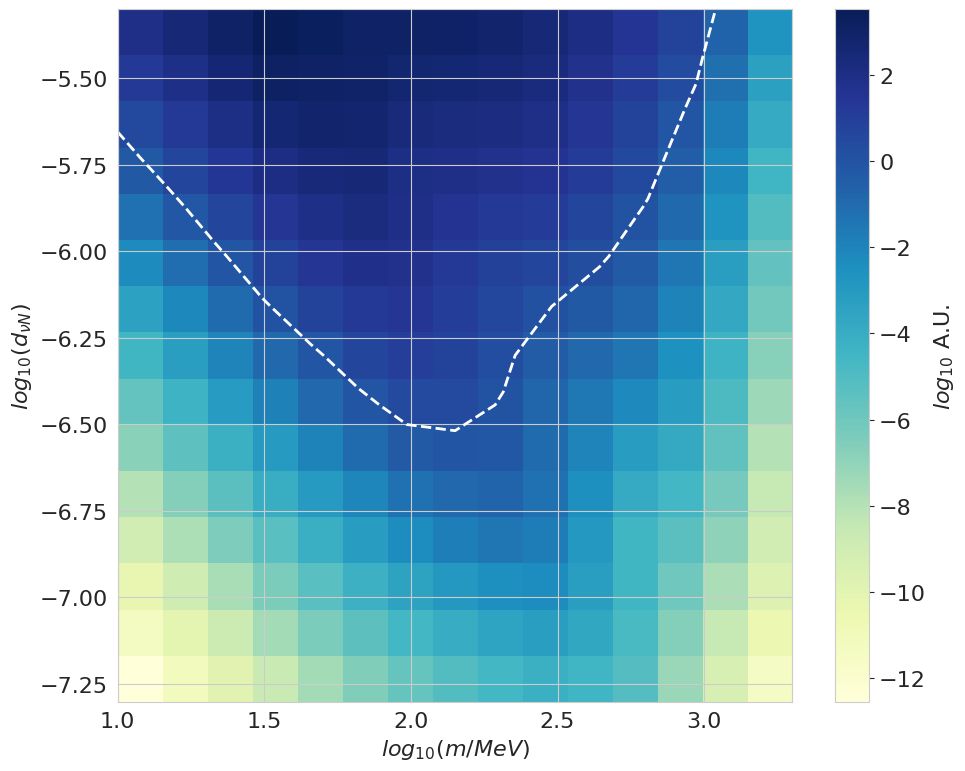

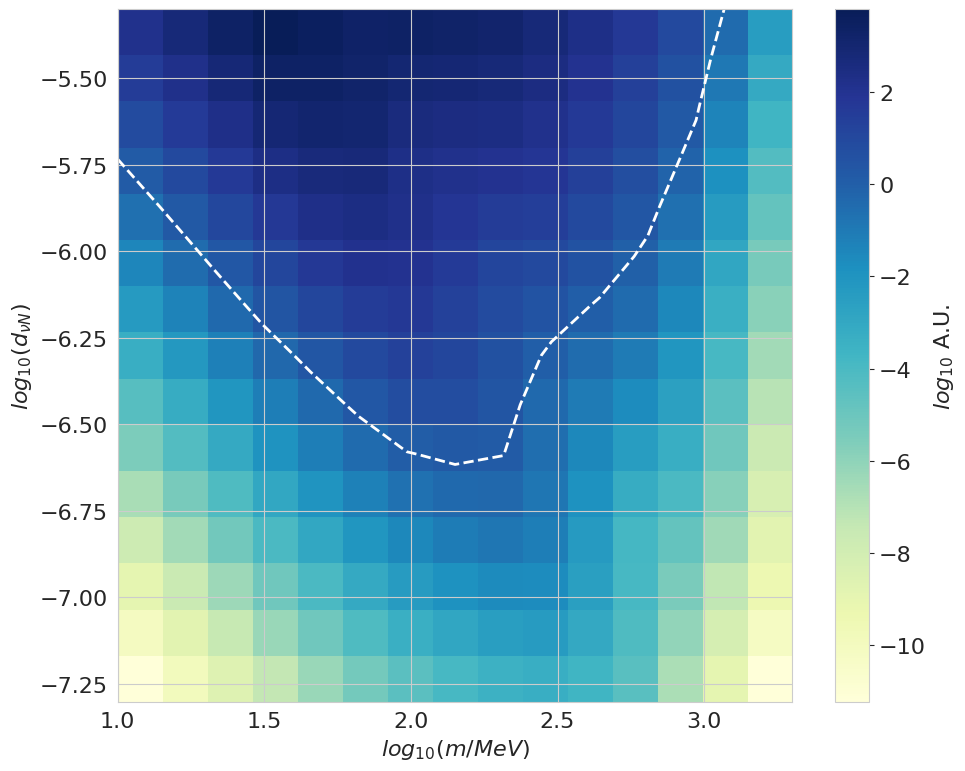

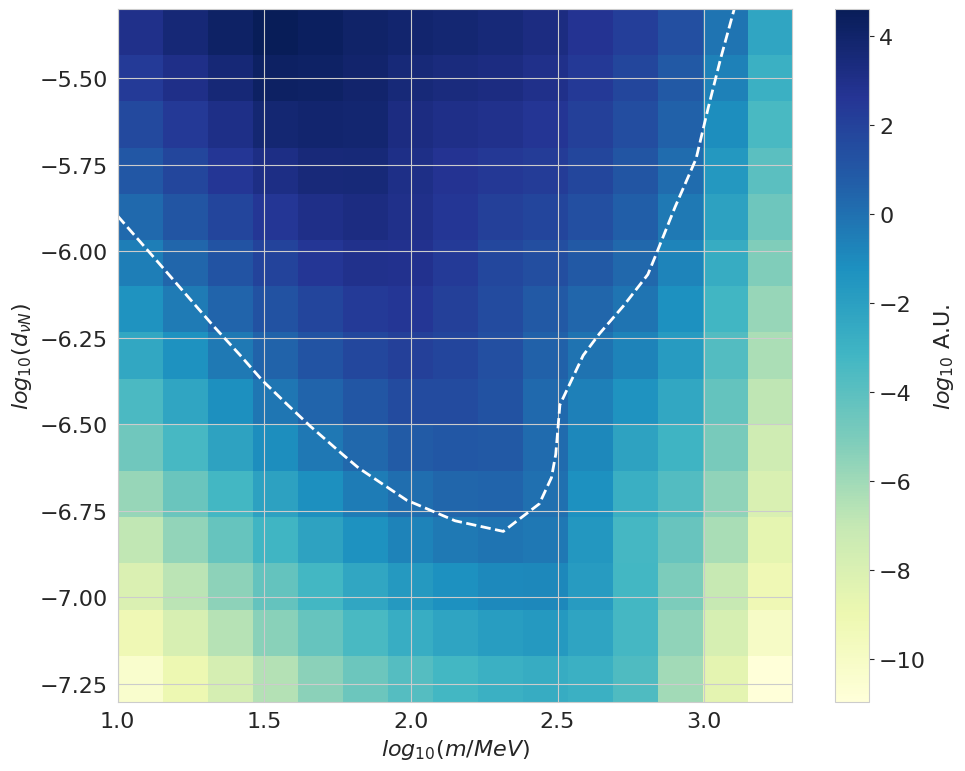

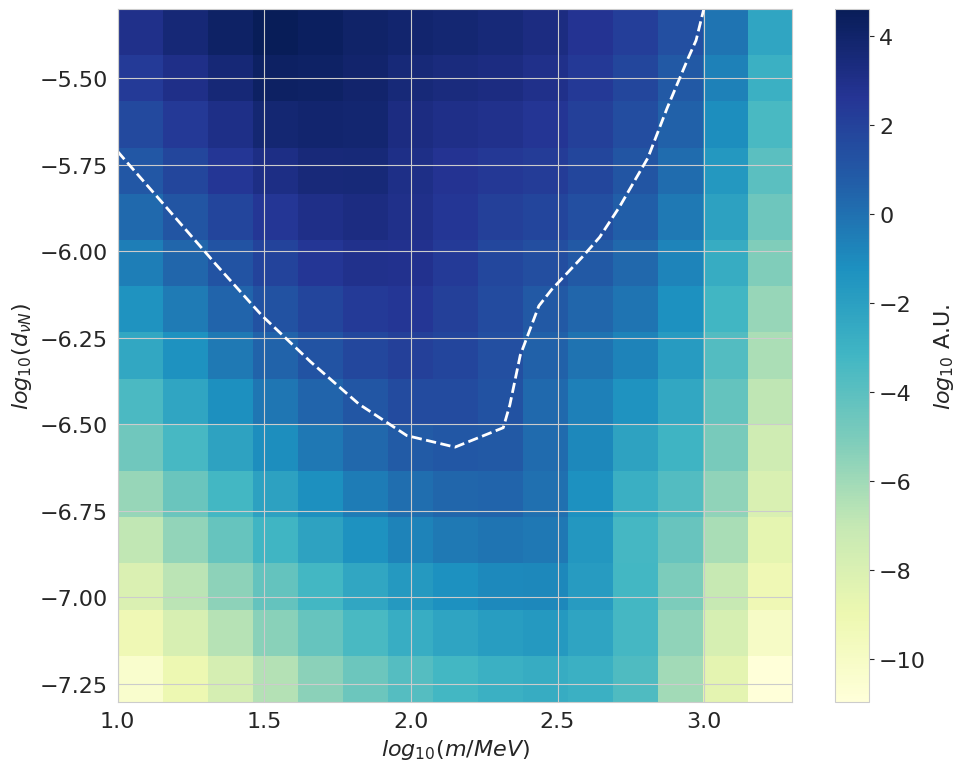

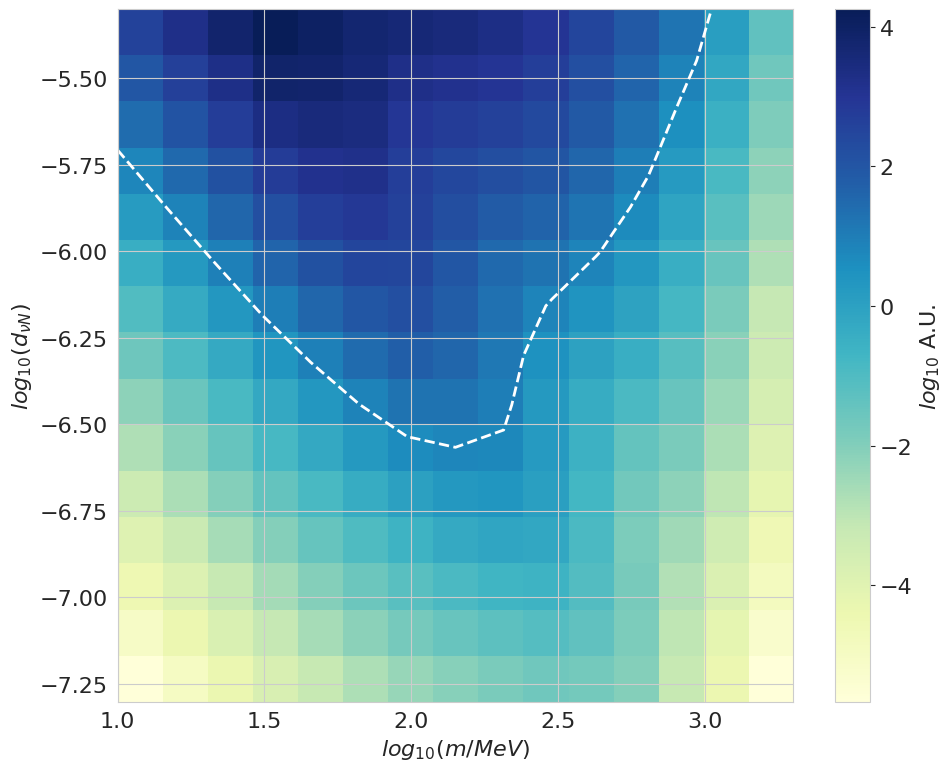

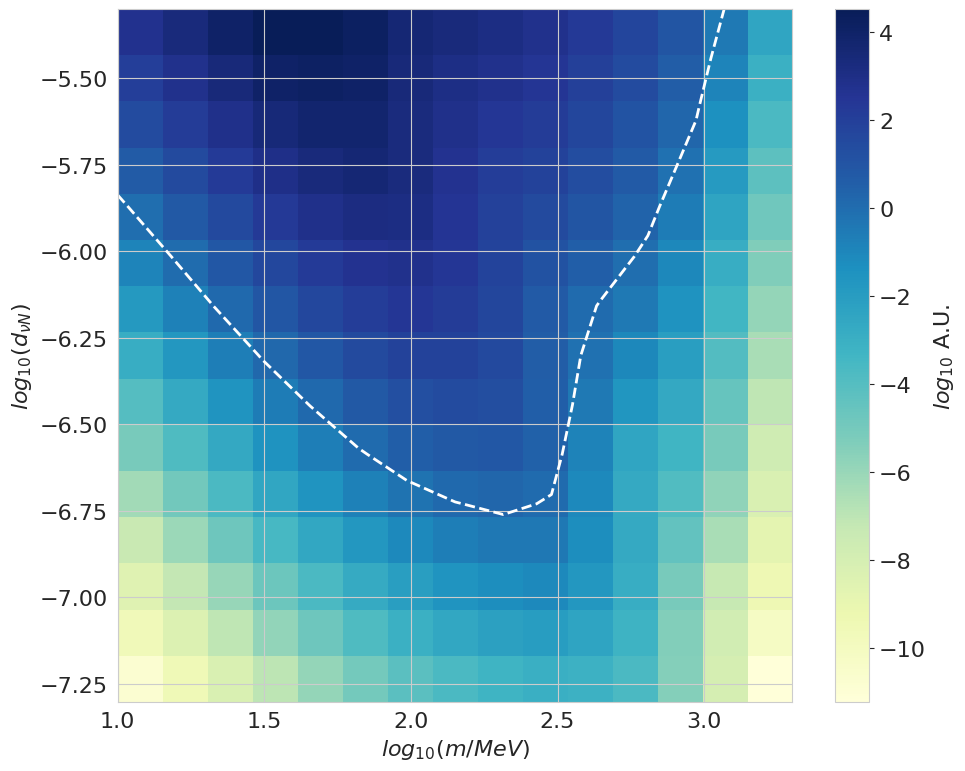

In [6]:
x, y, z3 = get_data_csv(exp = 'ND280+', year=3, mode='nu', scale='linear')
x, y, z3b = get_data_csv(exp = 'ND280+', year=3, mode='nubar', scale='linear')

x, y, z4 = get_data_csv(exp = 'ND280+', year=1, mode='nu', scale='linear')
x, y, z4b = get_data_csv(exp = 'ND280+', year=1, mode='nubar', scale='linear')

x, y, z5 = get_data_csv(exp = 'ND280+', year=3, mode='nu', scale='linear',nobump=True)
x, y, z5b = get_data_csv(exp = 'ND280+', year=3, mode='nubar', scale='linear',nobump=True)

z3 = logLR(z3,key='ND280+_nu')
z3b = logLR(z3b,key='ND280+_nubar')

z4 = logLR(z4,key='ND280+_nu', year=1)
z4b = logLR(z4b,key='ND280+_nubar', year=1)

z5 = logLR(z5,key='ND280+_nu')
z5b = logLR(z5b,key='ND280+_nubar')

x, y, z0 = get_data_csv(exp='ND280',mode='nu',scale='linear')
x, y, z0b = get_data_csv(exp='ND280',mode='nubar',scale='linear')

x, y, z1 = get_data_csv(exp='ND280_proj',mode='nu',scale='linear')
x, y, z1b = get_data_csv(exp='ND280_proj',mode='nubar',scale='linear')

z0 = logLR(z0,key='ND280_nu_2019')
z0b = logLR(z0b,key='ND280_nu_2019')

z1 = logLR(z1,key='ND280_nu_2019to2023')
z1b = logLR(z1b,key='ND280_nubar_2019to2023')

_, _, fgdz, fgdzb = obtain_fgd_signal()
fgdz = logLR(fgdz,key='sfgd')
fgdzb = logLR(fgdzb,key='sfgd')

create_pixel_plot(x, y, z0+z0b, tar(0.95), scale='log', save_str='../main_plot/t2k', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b, tar(0.95), scale='log', save_str='../main_plot/t2kfull', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z3b+z3, tar(0.95), scale='log', save_str='../main_plot/t2kfullnII', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z3b+z3, tar(0.9999997), scale='log', save_str='../main_plot/t2k5sigma', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z4b+z4, tar(0.999936658), scale='log', save_str='../main_plot/t2k4sigmayear1', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z5b+z5, tar(0.95), scale='log', save_str='../main_plot/t2knobump', zoom_factor=1.5)

# z4 = z0/POT['ND280_nu_2019']*POT['ND280+_nu']
# z4 = logLR(z4,key='ND280+_nu')
# create_pixel_plot(x, y, z4, tar(0.95), scale='log', zoom_factor=3)
# create_pixel_plot(x, y, z3, tar(0.95), scale='log', zoom_factor=3)


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='$log_{10}(m/MeV)$', ylabel='$log_{10}(d_{\\nu N})$'>,
 <matplotlib.contour.QuadContourSet at 0x1546289cbce0>)

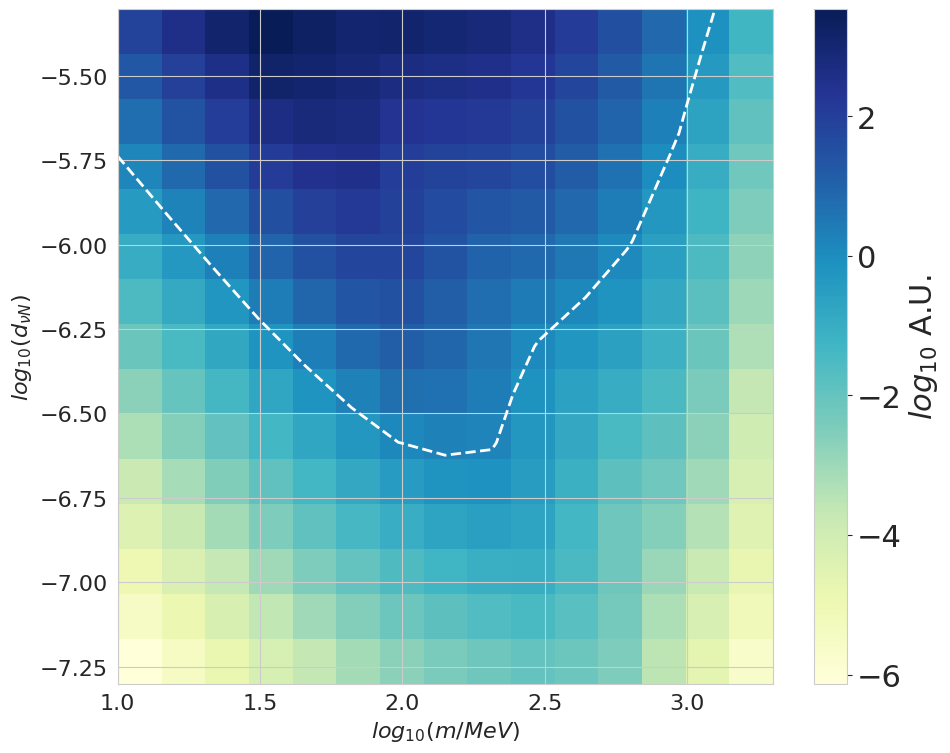

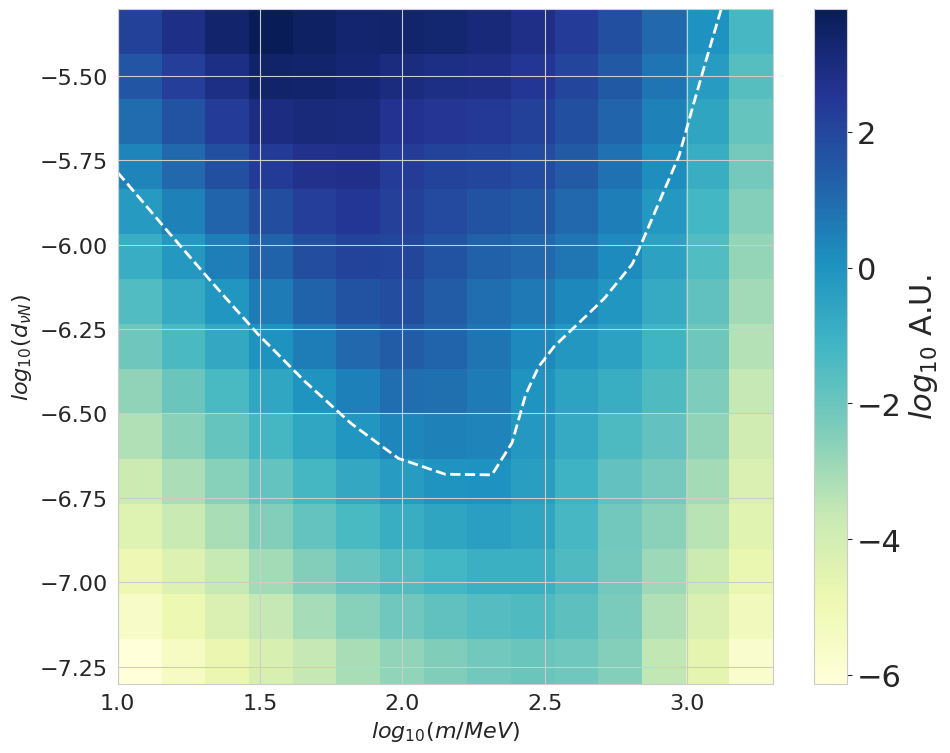

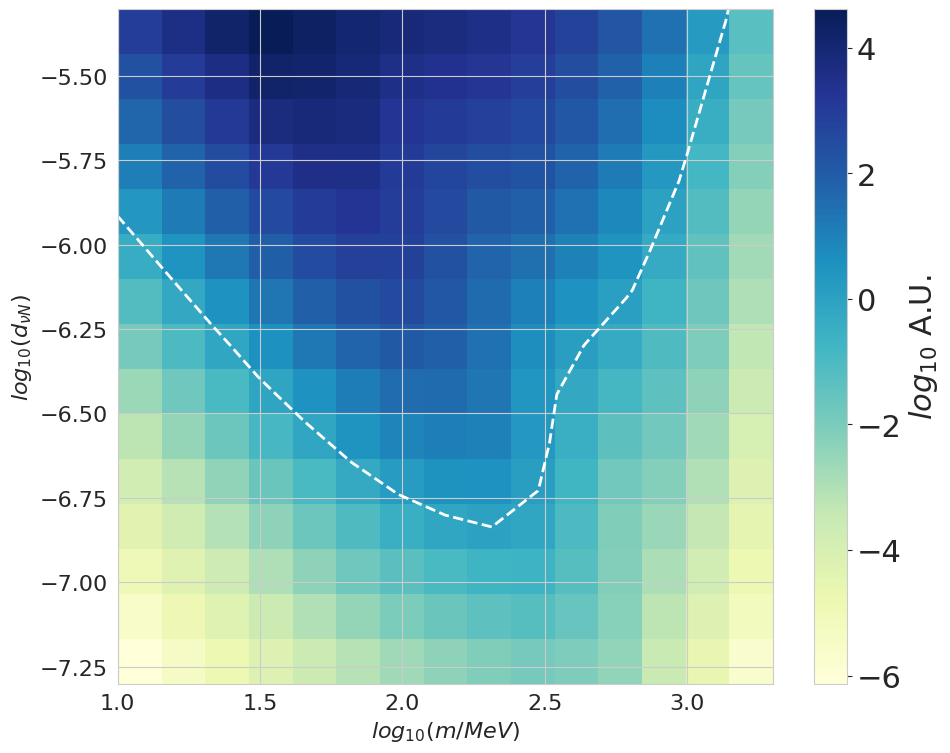

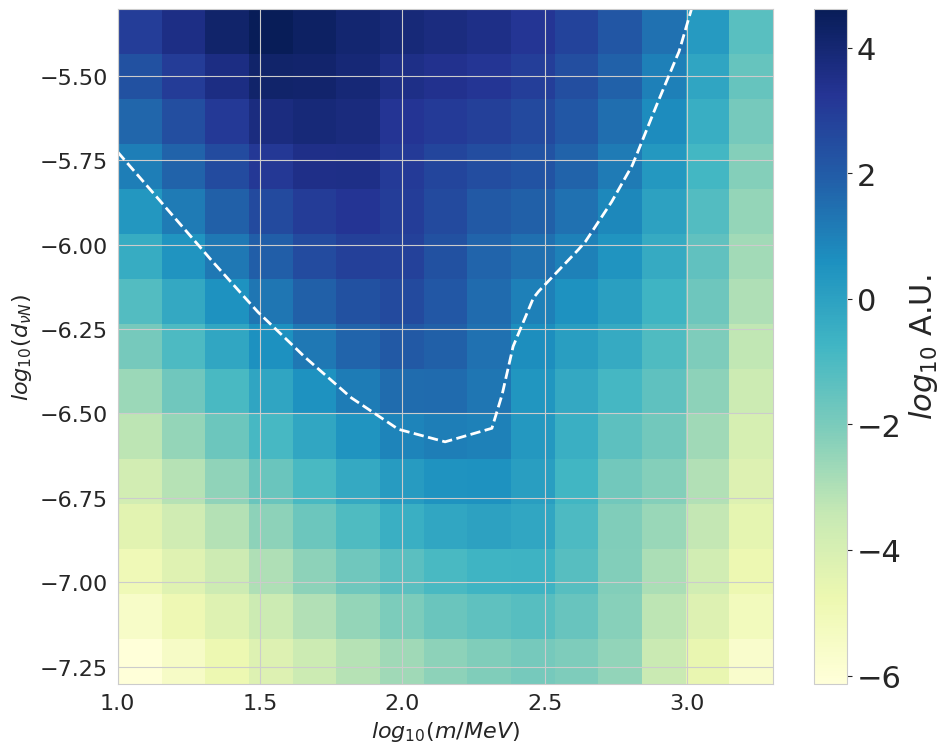

In [49]:
x, y, z3 = get_data_csv(exp = 'ND280+', year=3, mode='nu', scale='linear')
x, y, z3b = get_data_csv(exp = 'ND280+', year=3, mode='nubar', scale='linear')

x, y, z4 = get_data_csv(exp = 'ND280+', year=1, mode='nu', scale='linear')
x, y, z4b = get_data_csv(exp = 'ND280+', year=1, mode='nubar', scale='linear')

x, y, z5 = get_data_csv(exp = 'ND280+', year=3, mode='nu', scale='linear',nobump=True)
x, y, z5b = get_data_csv(exp = 'ND280+', year=3, mode='nubar', scale='linear',nobump=True)

z3 = logLR(z3,key='ND280+_nu')
z3b = logLR(z3b,key='ND280+_nubar')

z4 = logLR(z4,key='ND280+_nu', year=1)
z4b = logLR(z4b,key='ND280+_nubar', year=1)

z5 = logLR(z5,key='ND280+_nu')
z5b = logLR(z5b,key='ND280+_nubar')

x, y, z0 = get_data_csv(exp='ND280',mode='nu',scale='linear')
x, y, z0b = get_data_csv(exp='ND280',mode='nubar',scale='linear')

x, y, z1 = get_data_csv(exp='ND280_proj',mode='nu',scale='linear')
x, y, z1b = get_data_csv(exp='ND280_proj',mode='nubar',scale='linear')

z0 = logTS_zero(z0,key='ND280_nu_2019')
z0b = logTS_zero(z0b,key='ND280_nu_2019')

z1 = logLR(z1,key='ND280_nu_2019to2023')
z1b = logLR(z1b,key='ND280_nubar_2019to2023')


create_pixel_plot(x, y, z0+z0b, tar(0.95), scale='log', save_str='../main_plot/t2k_new', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b, tar(0.95), scale='log', save_str='../main_plot/t2kfull_new', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z3b+z3, tar(0.95), scale='log', save_str='../main_plot/t2kfullnII_new', zoom_factor=1.5)
# create_pixel_plot(x, y, z0+z0b, tar(0.999936657516), scale='log', save_str='../main_plot/ConstraintFiles/t2k5sigma_new', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z3b+z3, tar(0.9999994267), scale='log', save_str='../main_plot/ConstraintFiles/t2k5sigma', zoom_factor=1.5)

# z4 = z0/POT['ND280_nu_2019']*POT['ND280+_nu']
# z4 = logLR(z4,key='ND280+_nu')
# create_pixel_plot(x, y, z4, tar(0.95), scale='log', zoom_factor=3)
# create_pixel_plot(x, y, z3, tar(0.95), scale='log', zoom_factor=3)


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='$log_{10}(m/MeV)$', ylabel='$log_{10}(d_{\\nu N})$'>,
 <matplotlib.contour.QuadContourSet at 0x1475aab5cda0>)

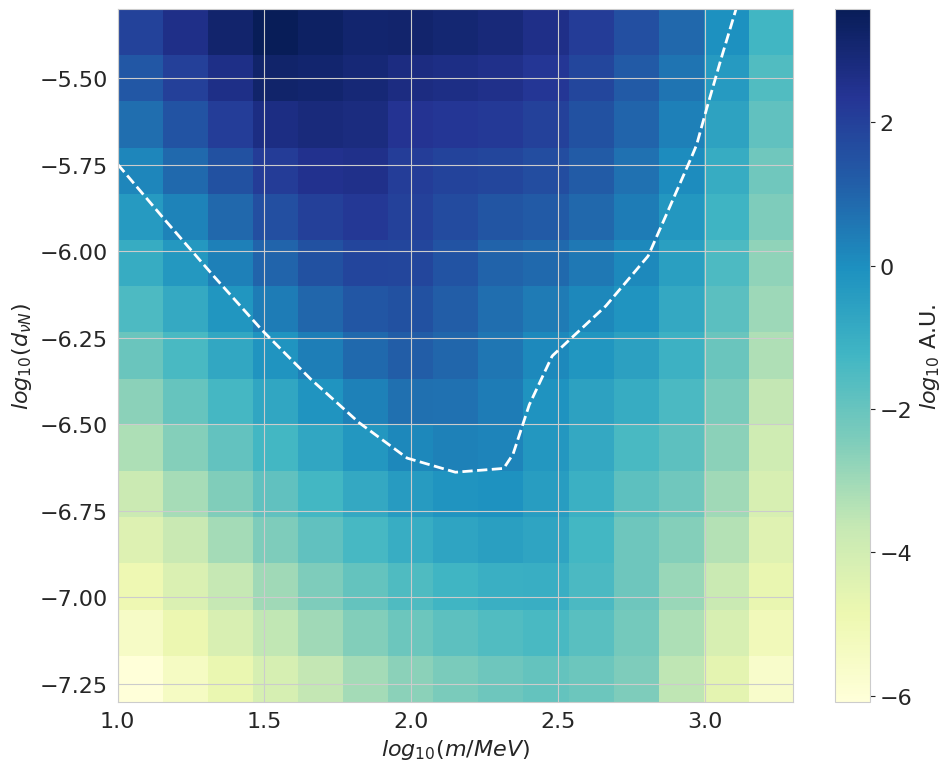

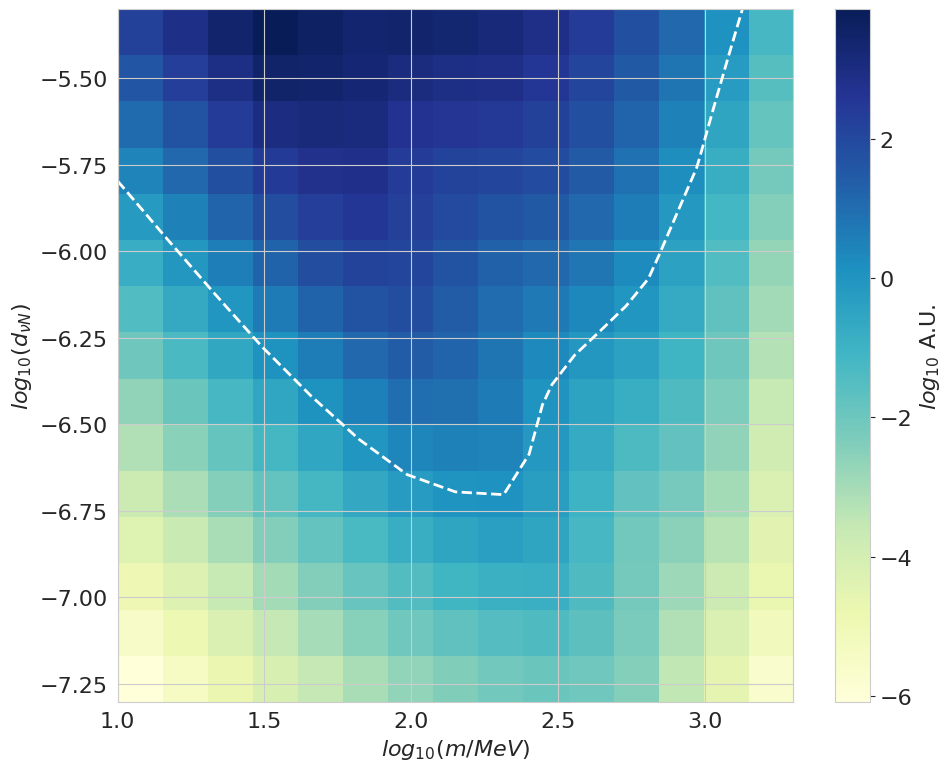

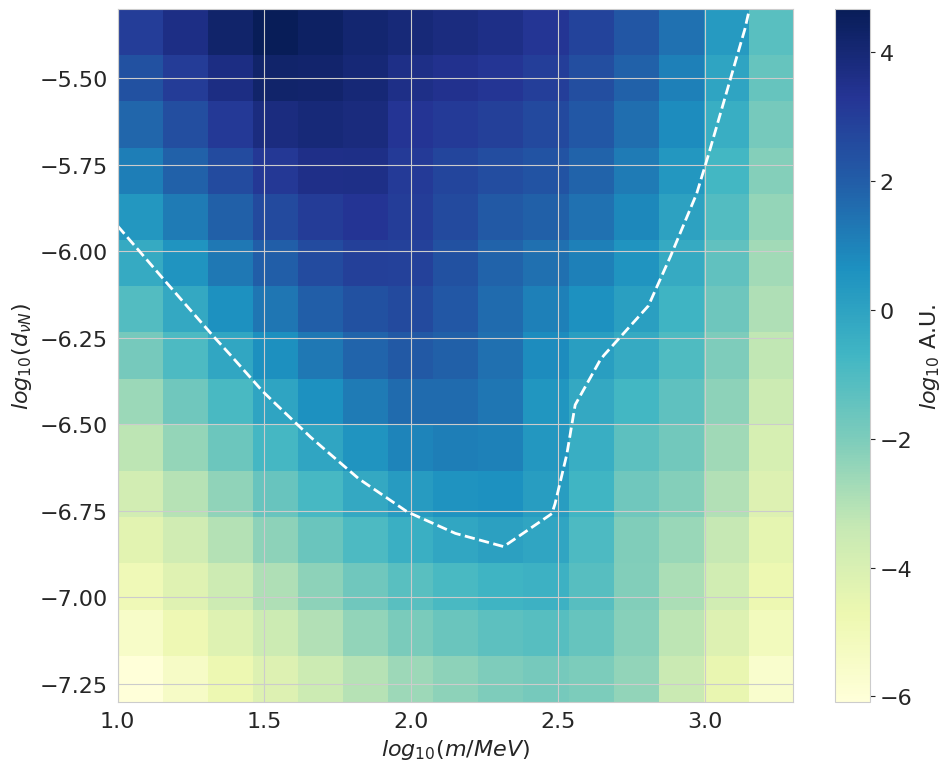

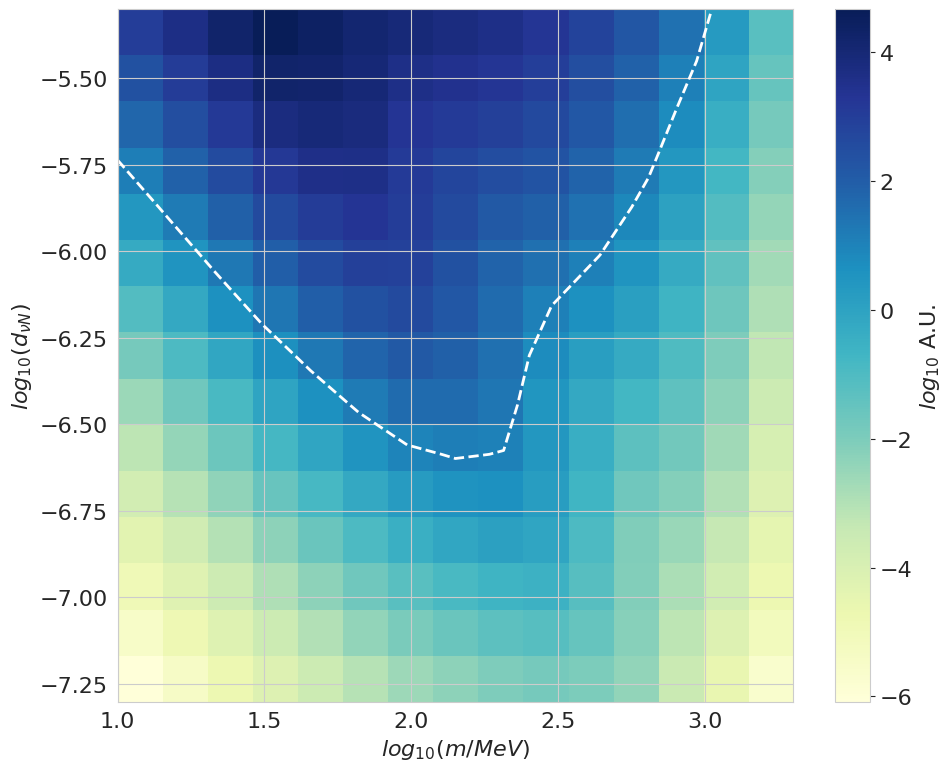

In [7]:
x, y, z3 = get_data_csv(exp = 'ND280+', year=3, mode='nu', scale='linear',err='up')
x, y, z3b = get_data_csv(exp = 'ND280+', year=3, mode='nubar', scale='linear',err='up')

x, y, z4 = get_data_csv(exp = 'ND280+', year=1, mode='nu', scale='linear',err='up')
x, y, z4b = get_data_csv(exp = 'ND280+', year=1, mode='nubar', scale='linear',err='up')

x, y, z5 = get_data_csv(exp = 'ND280+', year=3, mode='nu', scale='linear',nobump=True,err='up')
x, y, z5b = get_data_csv(exp = 'ND280+', year=3, mode='nubar', scale='linear',nobump=True,err='up')

z3 = logLR(z3,key='ND280+_nu')
z3b = logLR(z3b,key='ND280+_nubar')

z4 = logLR(z4,key='ND280+_nu', year=1)
z4b = logLR(z4b,key='ND280+_nubar', year=1)

z5 = logLR(z5,key='ND280+_nu')
z5b = logLR(z5b,key='ND280+_nubar')

x, y, z0 = get_data_csv(exp='ND280',mode='nu',scale='linear',err='up')
x, y, z0b = get_data_csv(exp='ND280',mode='nubar',scale='linear',err='up')

x, y, z1 = get_data_csv(exp='ND280_proj',mode='nu',scale='linear',err='up')
x, y, z1b = get_data_csv(exp='ND280_proj',mode='nubar',scale='linear',err='up')

z0 = logTS_zero(z0,key='ND280_nu_2019')
z0b = logTS_zero(z0b,key='ND280_nu_2019')

z1 = logLR(z1,key='ND280_nu_2019to2023')
z1b = logLR(z1b,key='ND280_nubar_2019to2023')


create_pixel_plot(x, y, z0+z0b, tar(0.95), scale='log', save_str='../main_plot/t2k_new_UP', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b, tar(0.95), scale='log', save_str='../main_plot/t2kfull_new_UP', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z3b+z3, tar(0.95), scale='log', save_str='../main_plot/t2kfullnII_new_UP', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b+z1+z1b+z3b+z3, tar(0.9999994267), scale='log', save_str='../main_plot/t2k5sigma_UP', zoom_factor=1.5)

/tmp/ipykernel_32804/1453159094.py:25: RuntimeWarning: divide by zero encountered in log10
  z = np.log10(z) if scale=='log' else z


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='$log_{10}(m/MeV)$', ylabel='$log_{10}(d_{\\nu N})$'>,
 <matplotlib.contour.QuadContourSet at 0x15343ff0ef60>)

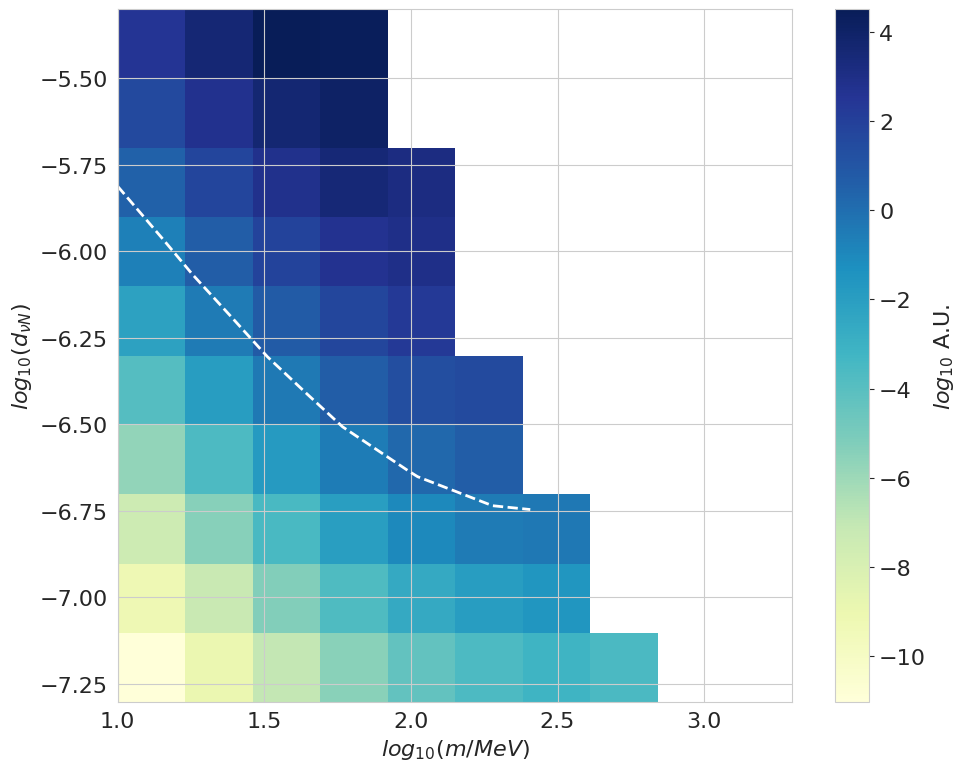

In [6]:
create_pixel_plot(x, y, z5b+z5, tar(0.95), scale='log', save_str='../main_plot/nobump', zoom_factor=1)

(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='$log_{10}(m/MeV)$', ylabel='$log_{10}(d_{\\nu N})$'>,
 <matplotlib.contour.QuadContourSet at 0x15344416e360>)

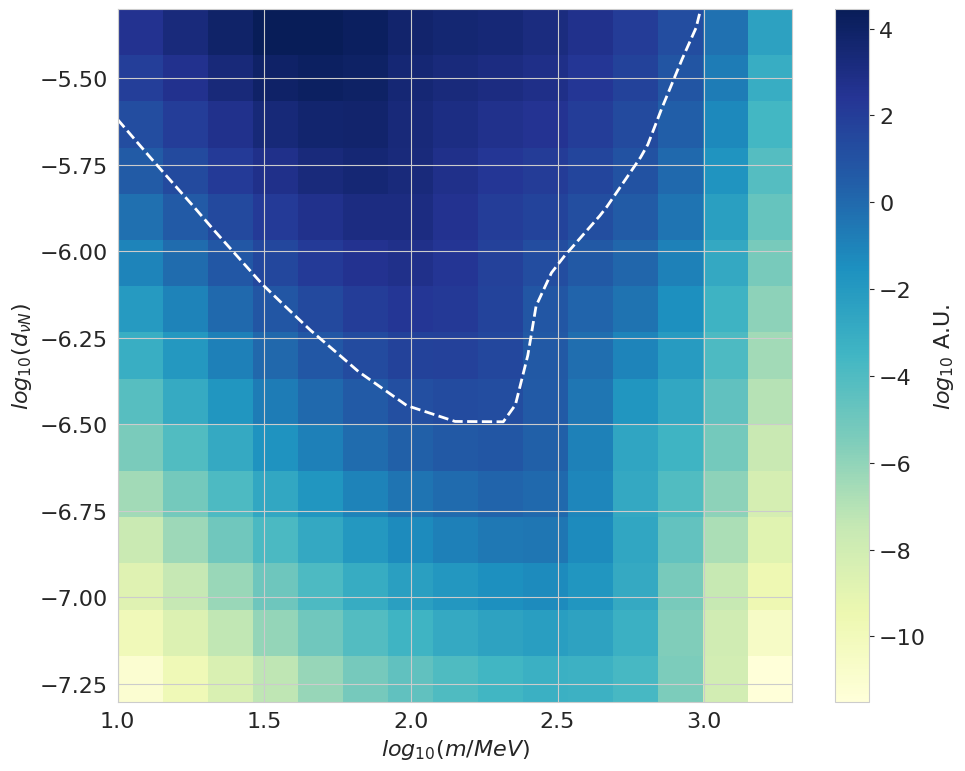

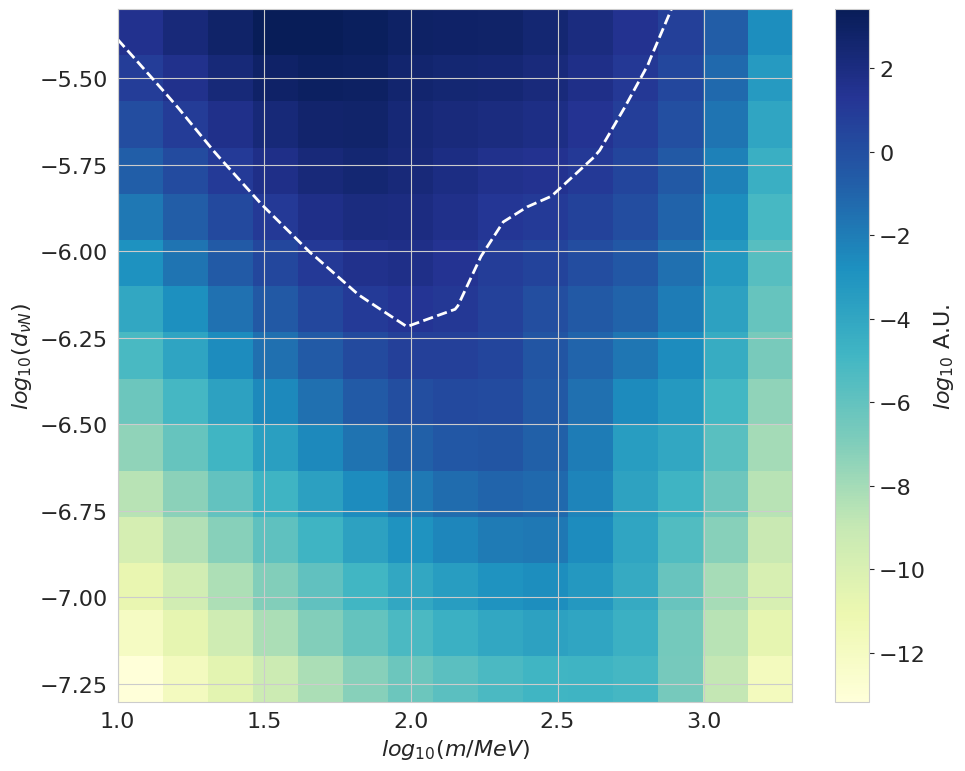

In [7]:
create_pixel_plot(x, y, z0+z0b+z3+z3b, tar(0.9999997), scale='log', save_str='5sigma_combo', zoom_factor=1.5)
create_pixel_plot(x, y, z0+z0b, tar(0.9999997), scale='log', save_str='5sigma', zoom_factor=1.5)

## Decay Distance Plot
Calculate weighted decay median from MC data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
from tqdm import tqdm
import awkward as ak
import pyarrow.parquet as pq

def weighted_median(data, weights):
    """Calculate the weighted median of a list of values."""
    data, weights = np.array(data), np.array(weights)
    sorted_indices = np.argsort(data)
    data, weights = data[sorted_indices], weights[sorted_indices]
    cumsum = np.cumsum(weights)
    midpoint = 0.5 * cumsum[-1]
    if np.any(weights > midpoint):
        return data[weights == np.max(weights)][0]
    idx = np.searchsorted(cumsum, midpoint, side='right')
    if cumsum[idx-1] == midpoint:
        return np.mean(data[idx-1:idx+1])
    return data[idx]

def process_samples(m_sample, mu_sample, base_path="../MC/output_nu_NEW/"):
    weighted_med = {}
    for m4, tr4 in tqdm(zip(m_sample, mu_sample), total=len(m_sample), desc="Processing samples"):
        path = f"{base_path}TPC5_Dipole_M{m4:.2e}_mu{tr4:.2e}_example.parquet"
        if os.path.isfile(path):
            data = ak.from_parquet(path)
            weight = ak.to_numpy(data['event_weight'])
            vertex = ak.to_numpy(data['vertex'])
            dist = np.linalg.norm(vertex[:, 0] - vertex[:, 1], axis=1)
            weighted_med[(m4, tr4)] = weighted_median(dist, weight)
    return weighted_med

def extract_xyz(data_dict):
    keys = np.array(list(data_dict.keys()))
    values = np.array(list(data_dict.values()))
    return keys[:, 0], keys[:, 1], values

weighted_med = process_samples(m_sample, mu_sample)
x, y, z = extract_xyz(weighted_med)

Processing samples: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


### Calculate Analytic Weighted Median Decay Distance 
Assumes incoming energy flux from T2K neutrino data

<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2104477/239609922.py:80: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mu_{tr}$')
Calculating distances:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating distances: 100%|██████████| 500/500 [00:03<00:00, 135.98it/s]
/tmp/ipykernel_2104477/239609922.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, collection in enumerate(contour.collections):


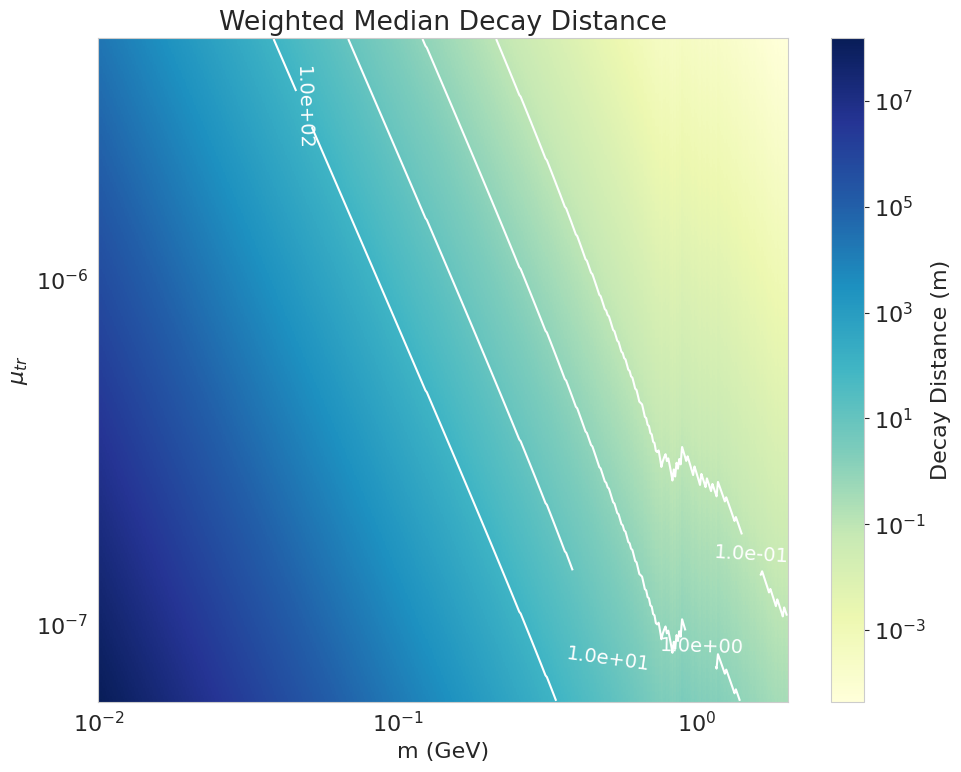

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm

# Constants
HBAR = 6.582119569e-25  # Reduced Planck constant (J·s)
C = 2.998e8  # Speed of light (m/s)
HBAR_C = HBAR * C

def calculate_decay_distance(E, mN, mu):
    return (16 * np.pi * np.sqrt(((E/mN)**2-1))) / (mu**2 * mN**3) * HBAR_C

def weighted_median_decay_distance(energies, weights, M, Mu):
    mask = energies >= M
    filtered_energies = energies[mask]
    filtered_weights = weights[mask]
    
    if len(filtered_energies) == 0:
        return np.nan
    
    decay_distances = calculate_decay_distance(filtered_energies, M, Mu)
    sorted_indices = np.argsort(decay_distances)
    sorted_distances = decay_distances[sorted_indices]
    sorted_weights = filtered_weights[sorted_indices]
    
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    median_index = np.searchsorted(cumulative_weights, total_weight / 2)
    
    return sorted_distances[median_index]

def plot_decay_distance_heatmap(m_range, mu_range, num_points=100, num_contours=10):
    # Load data once
    data = np.loadtxt('flux.dat')
    energies, weights = data[:, 0], data[:, 1]

    # Create logarithmically spaced points for m and mu
    m_values = np.geomspace(m_range[0], m_range[1], num_points)
    mu_values = np.geomspace(mu_range[0], mu_range[1], num_points)
    
    # Initialize the distance array
    distances = np.zeros((num_points, num_points))
    
    # Use numpy broadcasting to create a 2D array of M values
    M_2D = m_values[:, np.newaxis]
    
    # Calculate the decay distance for each pair of m and mu
    for j, mu in enumerate(tqdm(mu_values, desc="Calculating distances")):
        distances[:, j] = [weighted_median_decay_distance(energies, weights, m, mu) for m in m_values]
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create the heatmap
    im = ax.pcolormesh(m_values, mu_values, distances.T, norm=LogNorm(), shading='auto')
    
    # Add contour lines
    levels = [0.1, 1, 10, 100]
    contour = ax.contour(m_values, mu_values, distances.T, levels=levels, colors='white', alpha=1)
    ax.clabel(contour, inline=True, fontsize=14, fmt='%.1e')
    
    # Save contour data
    with open('analytic_distance_contour.txt', 'w') as f:
        for i, collection in enumerate(contour.collections):
            for path in collection.get_paths():
                vertices = path.vertices
                f.write(f"Contour Level: {levels[i]}\n")
                np.savetxt(f, vertices, fmt='%.16f', delimiter='\t')
                f.write("\n")
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, label='Decay Distance (m)')
    cbar.ax.yaxis.set_tick_params(which='both', direction='out')
    
    # Set scale and labels
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('m (GeV)')
    ax.set_ylabel('$\mu_{tr}$')
    ax.set_title('Weighted Median Decay Distance')
    
    plt.tight_layout()
    plt.show()

# Example usage
m_range = (1e-2, 2)  # GeV
mu_range = (6e-8, 5e-6)  # mu
plot_decay_distance_heatmap(m_range, mu_range, num_points=500)

/tmp/ipykernel_1012853/1170788768.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, fontsize=20)
/tmp/ipykernel_1012853/1170788768.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels, fontsize=20)


[-7.30103    -7.30103    -7.30103    -7.30103    -7.30103    -7.30103
 -7.30103    -7.30103    -7.30103    -7.30103    -7.07880777 -7.07880777
 -7.07880777 -7.07880777 -7.07880777 -7.07880777 -7.07880777 -7.07880777
 -7.07880777 -7.07880777 -6.85658555 -6.85658555 -6.85658555 -6.85658555
 -6.85658555 -6.85658555 -6.85658555 -6.85658555 -6.85658555 -6.85658555
 -6.63436333 -6.63436333 -6.63436333 -6.63436333 -6.63436333 -6.63436333
 -6.63436333 -6.63436333 -6.63436333 -6.63436333 -6.41214111 -6.41214111
 -6.41214111 -6.41214111 -6.41214111 -6.41214111 -6.41214111 -6.41214111
 -6.41214111 -6.41214111 -6.18991888 -6.18991888 -6.18991888 -6.18991888
 -6.18991888 -6.18991888 -6.18991888 -6.18991888 -6.18991888 -6.18991888
 -5.96769666 -5.96769666 -5.96769666 -5.96769666 -5.96769666 -5.96769666
 -5.96769666 -5.96769666 -5.96769666 -5.96769666 -5.74547444 -5.74547444
 -5.74547444 -5.74547444 -5.74547444 -5.74547444 -5.74547444 -5.74547444
 -5.74547444 -5.74547444 -5.52325222 -5.52325222 -5.52

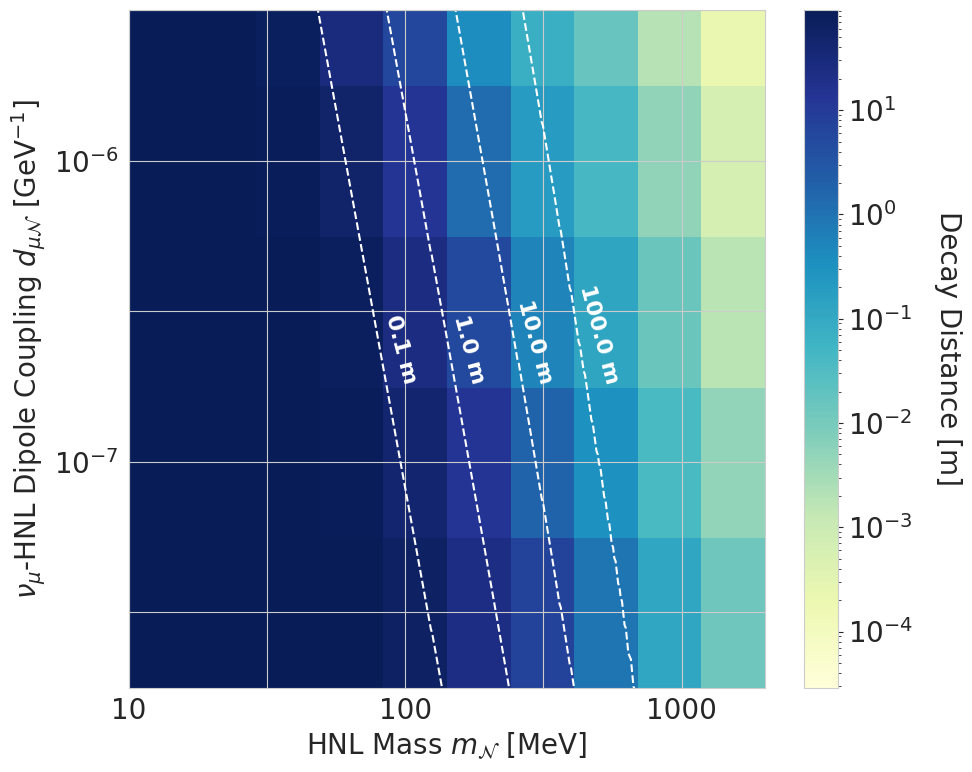

In [32]:
def process_contour_data(file_path):
    contours = {}
    current_level = None
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('Contour Level:'):
                current_level = float(line.split(':')[1])
                contours[current_level] = []
            elif line.strip() and current_level is not None:
                x, y = map(float, line.split())
                contours[current_level].append((x, y))
    return {level: np.array(points) for level, points in contours.items()}

def distance_pixel_plot(x, y, z, line_intercept=0, contour_file=None, scatter=None):
    
    x = np.log10(x*1000)
    y = np.log10(y/2)
    
    x_unique, y_unique = np.unique(x), np.unique(y)
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)
    
    for xi, yi, zi in zip(x, y, z):
        x_idx = np.searchsorted(x_unique, xi)
        y_idx = np.searchsorted(y_unique, yi)
        z_grid[y_idx, x_idx] = zi
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto', norm=LogNorm())
    
    cbar = plt.colorbar(im, label='Decay Distance [m]')
    cbar.ax.yaxis.label.set_rotation(270)
    cbar.ax.yaxis.label.set_va('bottom')
    cbar.ax.yaxis.label.set_fontsize(20)
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.yaxis.labelpad = 15
    
    # if contour_file:
    #     contours = process_contour_data(contour_file)
    #     for level, points in contours.items():
    #         cs = ax.plot(np.log10(points[:, 0]*1000), np.log10(points[:, 1]/2), 
    #                 color='white', label=f'Contour {level}', linestyle='--')
    #         ax.clabel(cs, inline=True, fmt=f'{level:.1f} m', fontsize=10)
    
    if contour_file:
        contours = process_contour_data(contour_file)
        for n, (level, points) in enumerate(contours.items()):
            X = np.log10(points[:, 0]*1000)
            Y = np.log10(points[:, 1]/2)
            ax.plot(X, Y, 'w--', linewidth=1.5)
            
            # Choose a point for label (e.g., middle of the contour)
            mid_point = len(X) // 4
            x_dim = np.log10([80,140,240,400])
            ax.annotate(f'{level:.1f} m', (x_dim[n], -6.3), 
                        color='white', fontweight='bold', fontsize=16,
                        xytext=(3, 3), textcoords='offset points', rotation=285,
                        bbox=dict(facecolor='none', alpha=0.5, edgecolor='none'))
    
    ax.set_xlabel(r'HNL Mass $m_{\mathcal{N}}$ [MeV]', fontsize=20)
    ax.set_ylabel(r'$\nu_\mu$-HNL Dipole Coupling $d_{\mu \mathcal{N}}$ [GeV$^{-1}$]', fontsize=20)
    # ax.set_title('$\mathcal{N}$ Decay Distance', fontsize=20)

    # Get current x-ticks
    xticks = ax.get_xticks()
    # Convert log ticks to actual values
    xtick_labels = [f'{10**x:2.0f}' if x == int(x) else '' for x in xticks]
    ax.set_xticklabels(xtick_labels, fontsize=20)
    if scatter is not None:
        n_m = 10
        n_mu = 10
        m_sample = np.geomspace(1e-2,2,n_m)
        mu_sample = np.geomspace(1e-7,1e-5,n_mu)
        m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
        m_sample = np.reshape(m_sample,[n_m*n_mu])
        mu_sample = np.reshape(mu_sample,[n_m*n_mu])
        
        plt.scatter(np.log10(m_sample[scatter]*1000),np.log10(mu_sample[scatter]/2), s=200, c='green')
    # Get current y-ticks
    yticks = ax.get_yticks()
    print(y)
    # Convert log ticks to actual values
    ytick_labels = [f'$10^{{{y:1.0f}}}$' if y==int(y) else '' for y in yticks]
    ax.set_yticklabels(ytick_labels, fontsize=20)
    plt.ylim(-6.7,-5.8)
    plt.tight_layout()
    plt.savefig('distance.pdf')

    plt.show()

distance_pixel_plot(x, y, z, line_intercept=2, contour_file='analytic_distance_contour.txt')

TPC4_Dipole_M6.16e-01_mu4.64e-07_example.parquet


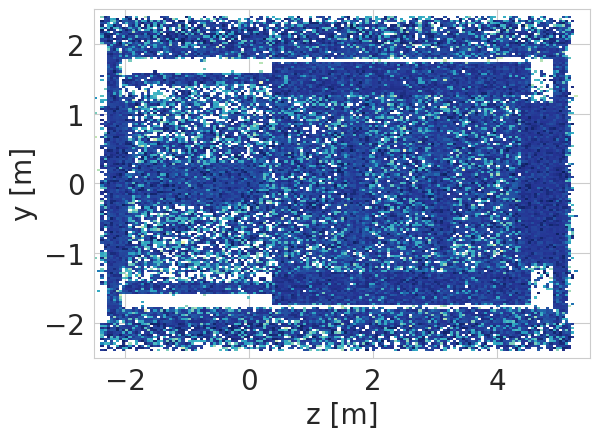

In [6]:

import os
import awkward as awk

plt.rcParams.update({'font.size':20,'image.cmap': 'YlGnBu'})

subpa = ['TPC4']

def position_plot(x,y,bins,labelx,labely,title,weights=None):
    
    plt.hist2d(x,y,bins=bins,norm=LogNorm(),weights=weights)
    # c = plt.colorbar()
    # c.set_label("Number of Generated Events")
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.tight_layout()
    

def plot_positions(data,range1,range2,slice1="x",slice2="y",savestr=None,tag='dec', binnum=100):
    dec_flag = data["primary_type"]==5914
    weights = np.array(data['event_weight'])*POT['ND280+_nu']

    
    axis1 = {"x":0,"y":1,"z":2}[slice1]
    axis2 = {"x":0,"y":1,"z":2}[slice2]
    
    bins = (np.linspace(range1[0],range1[1],binnum),
            np.linspace(range2[0],range2[1],binnum))
    
    fig, ax = plt.subplots()
    position_plot(np.array(data["vertex"][~dec_flag][:,0,axis1]),
                np.array(data["vertex"][~dec_flag][:,0,axis2]),
                bins,"%s [m]"%slice1,"%s [m]"%slice2,"Upscattering Vertex",weights=np.array(data['event_weight']))

    # # if savestr is not None:
    if savestr != None:
        plt.savefig('./figures/'+savestr,dpi=100)
        
    plt.show()



i=37
m4, tr4 = m_sample[i], mu_sample[i]

for s in subpa:
    path=s+"_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4, tr4)
    if os.path.isfile('../MC/output_final/'+path):
        print(path)
        data = awk.from_parquet("../MC/output_final/"+path)

    Emax = 5
    axis = 3
    ylim_E = 1e6; ylim_C = 1e6
    xrange = [-5,5]; yrange = [-2.5,2.5]; zrange = [-2.5,5.5]

    plot_positions(data,zrange,yrange,"z","y",tag='upscat',binnum=160)

Processing i=45 for TPC4: TPC4_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=45 for OGTPC1: OGTPC1_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=46 for TPC4: TPC4_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=46 for OGTPC1: OGTPC1_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=48 for TPC4: TPC4_Dipole_M1.11e+00_mu7.74e-07_example.parquet
Processing i=48 for OGTPC1: OGTPC1_Dipole_M1.11e+00_mu7.74e-07_example.parquet


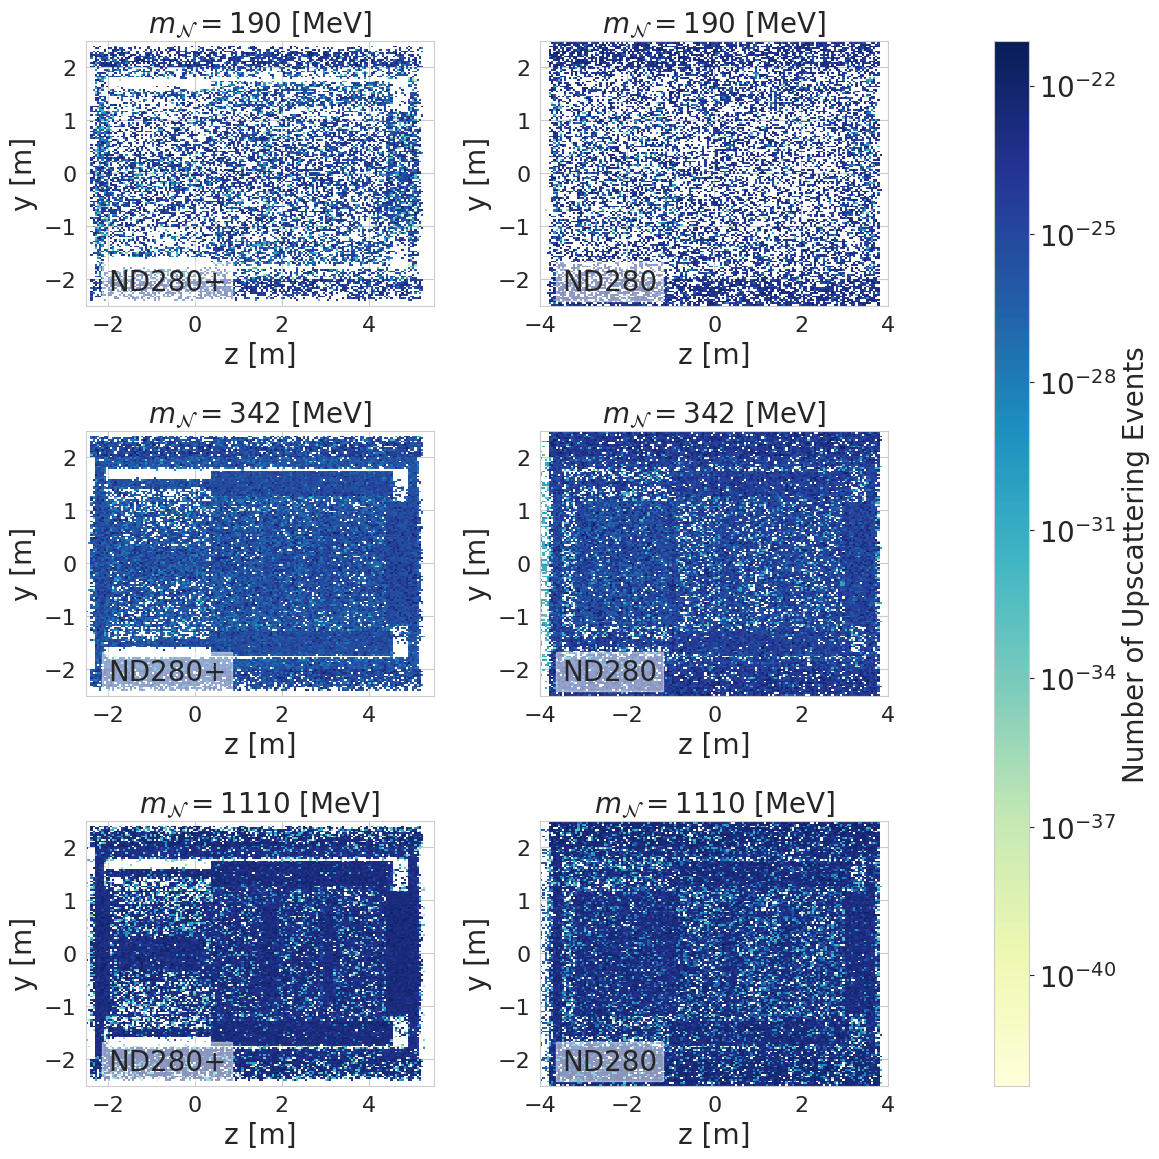

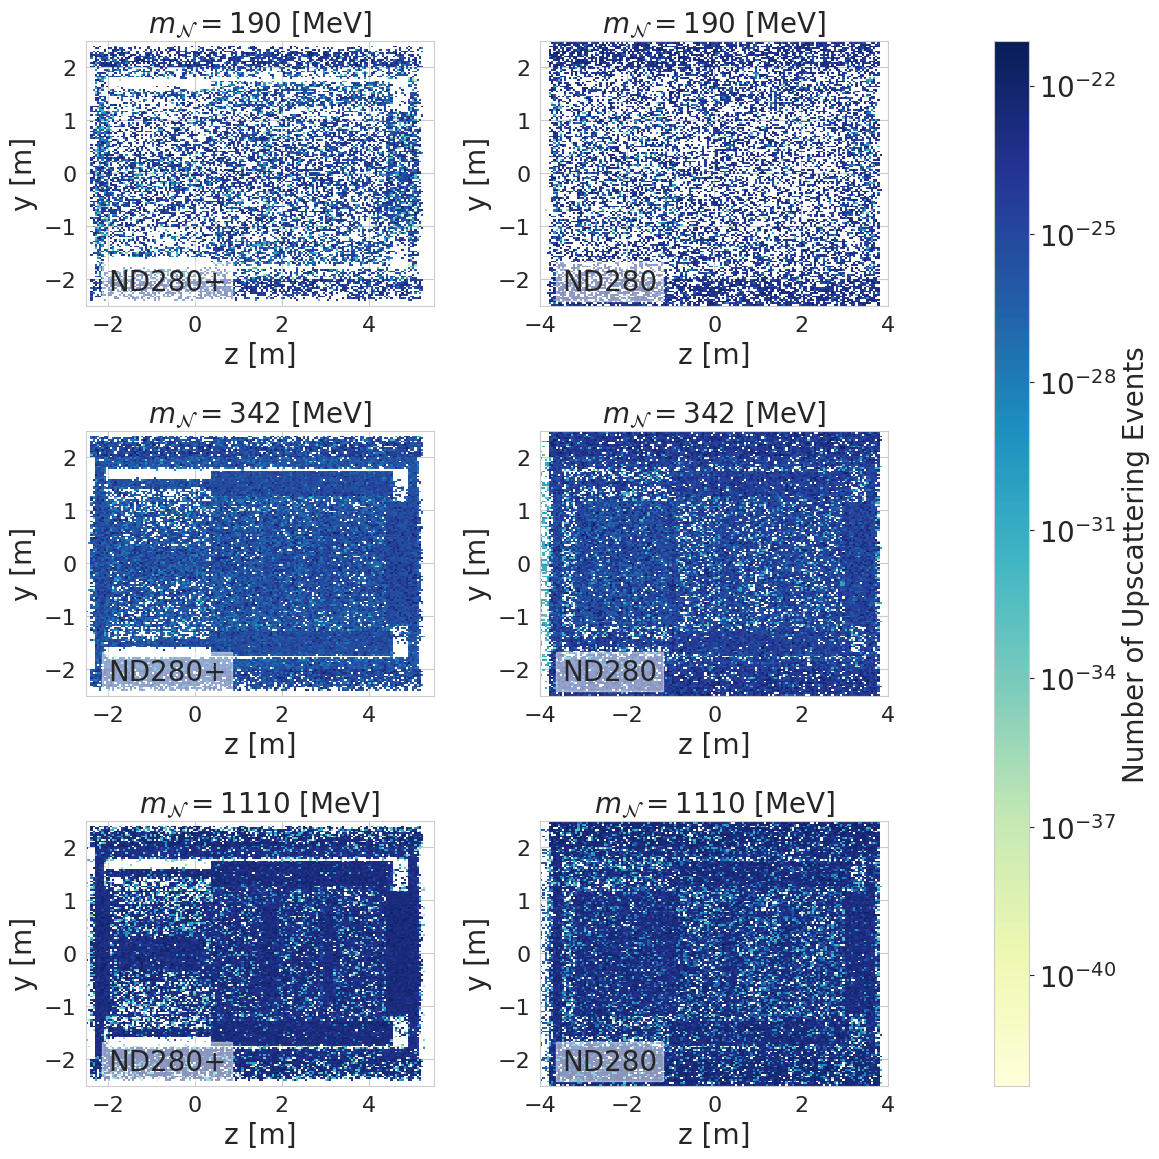

In [ ]:
import os
import awkward as awk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

plt.rcParams.update({'font.size': 20, 'image.cmap': 'YlGnBu'})

def position_plot(idx, ax, x, y, bins, labelx, labely, title, weights=None):
    pcm = ax.hist2d(x, y, bins=bins, norm=LogNorm(), weights=weights)
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(title, fontsize=20)
    ax.text(-2 if idx%2==0 else -3.5,-2.2,'ND280+' if idx%2==0 else 'ND280',bbox=dict(alpha=0.5,facecolor='white'))
    return pcm

def plot_grid_positions(i_values, m_sample, mu_sample, output_dir=None, weighted=False):
    # Create figure with 3x2 grid, with extra space for colorbar
    fig = plt.figure(figsize=(12, 12))  # Slightly wider to accommodate colorbar
    
    # Create GridSpec with space for colorbar
    gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 0.1])
    axes = []
    
    # Create all subplots
    for row in range(3):
        for col in range(2):
            axes.append(fig.add_subplot(gs[row, col]))
    
    # Create colorbar axis
    cbar_ax = fig.add_subplot(gs[:, -1])
    
    # Common ranges and bins
    xrange = [-5, 5]
    yrange = [-2.5, 2.5]
    zrange_ = [-2.5, 5.5]
    zrange = [-4,4]
    binnum = 160
    
    pcm = None  # Store the last plot for colorbar
    
    # Plot each subplot
    for idx, (ax, i) in enumerate(zip(axes, i_values)):
        if idx % 2 == 0:
            bins = (np.linspace(zrange_[0], zrange_[1], binnum),
                    np.linspace(yrange[0], yrange[1], binnum))
        else:
            bins = (np.linspace(zrange[0], zrange[1], binnum),
                    np.linspace(yrange[0], yrange[1], binnum))
            
        m4, tr4 = m_sample[i], mu_sample[i]
        
        # Determine which detector to use based on column (even/odd index)
        detector = 'TPC4' if idx % 2 == 0 else 'OGTPC1'
        
        path = detector + "_Dipole_M%2.2e_mu%2.2e_example.parquet" % (m4, tr4)
        if os.path.isfile('../MC/output_final/' + path):
            print(f"Processing i={i} for {detector}: {path}")
            data = awk.from_parquet("../MC/output_final/" + path)
            
            # Get vertex positions
            dec_flag = data["primary_type"] == 5914
            z_pos = np.array(data["vertex"][~dec_flag][:, 0, 2])  # z-axis
            y_pos = np.array(data["vertex"][~dec_flag][:, 0, 1])  # y-axis
            
            # Get weights if weighted
            weights = np.array(data['event_weight']) if weighted else None
            
            # Create plot
            pcm = position_plot(idx, ax, z_pos, y_pos, bins, 
                             "z [m]", "y [m]", 
                             r'$m_{\mathcal{N}} = $'+f"{m4*1000:3.0f} [MeV]",weights=weights)
    
    # Add colorbar
    if pcm is not None:
        plt.colorbar(pcm[3], cax=cbar_ax, label="Number of Upscattering Events")
    
    plt.tight_layout()
    
    # Handle file saving
    if output_dir is not None:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, 'event_density_grid.pdf')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")
    
    plt.show()
    return fig

# Example usage:
# i_values = [37,37,38,38,39,39]
i_values = [45,45,46,46,48,48]
output_dir = './figures'
plot_grid_positions(i_values, m_sample, mu_sample, output_dir=None, weighted=True)

/tmp/ipykernel_2134668/209155849.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ylgnbu = cm.get_cmap('YlGnBu')


Processing i=45 for TPC5: TPC5_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=46 for TPC5: TPC5_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=48 for TPC5: TPC5_Dipole_M1.11e+00_mu7.74e-07_example.parquet
Processing i=45 for OGTPC3: OGTPC3_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=46 for OGTPC3: OGTPC3_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=48 for OGTPC3: OGTPC3_Dipole_M1.11e+00_mu7.74e-07_example.parquet
Saved figure to ./figures/event_density_grid.pdf


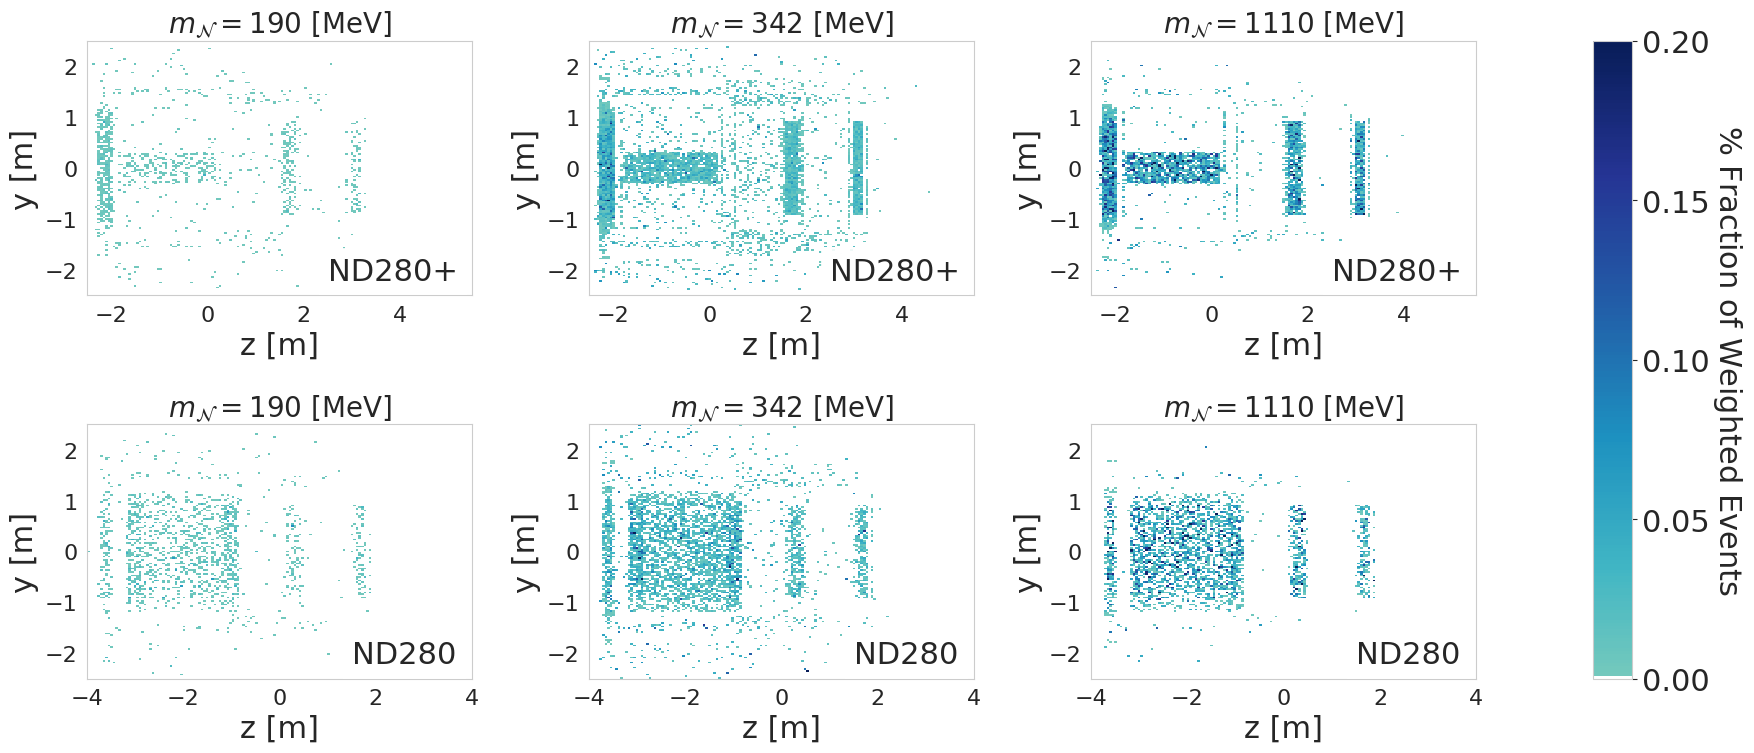

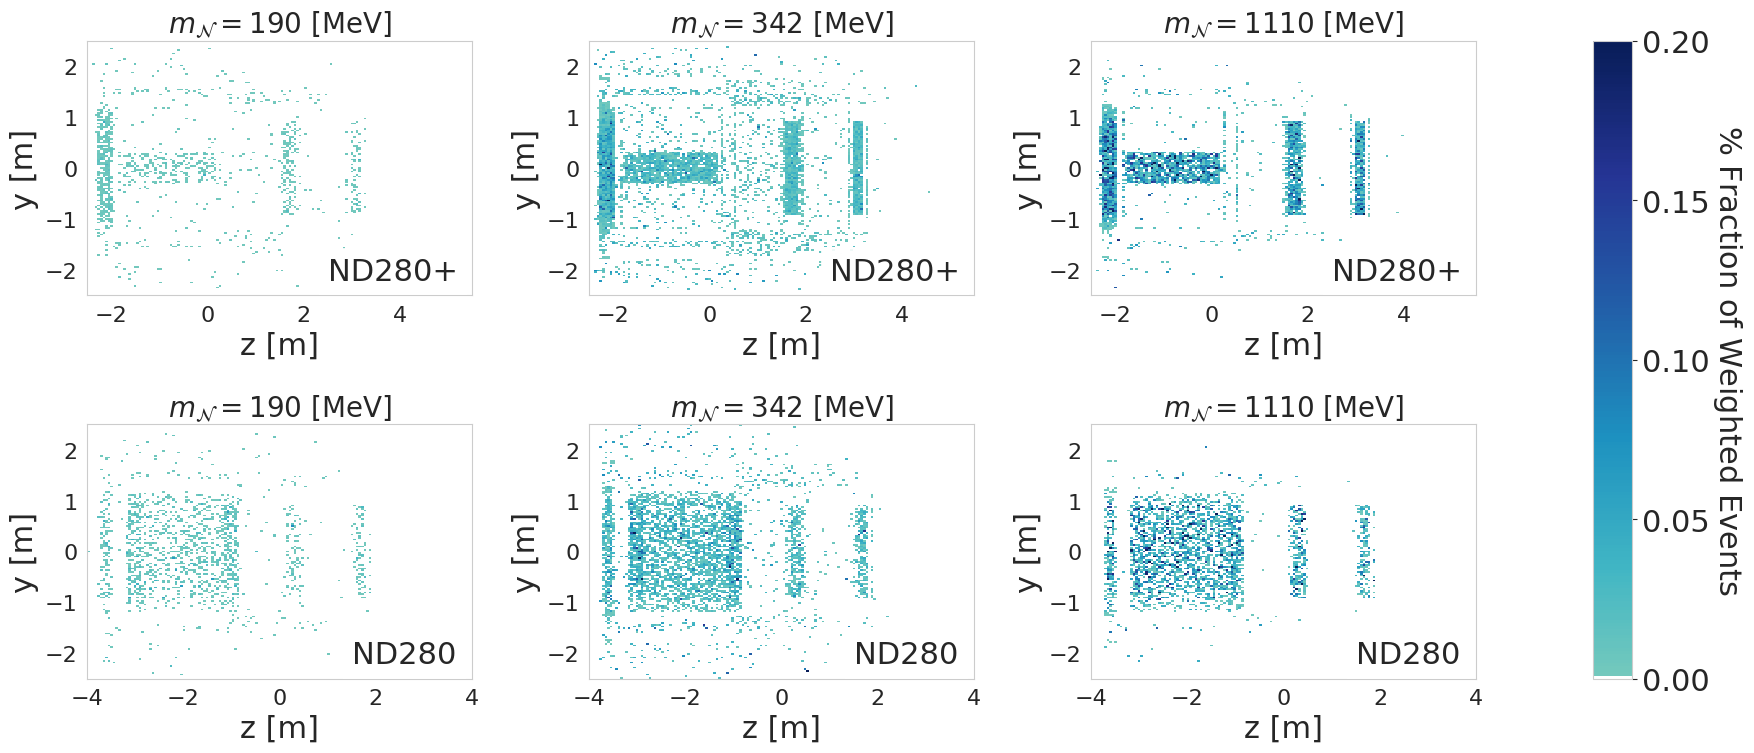

In [69]:
import os
import awkward as awk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams.update({'font.size': 22})

# Create custom colormap with white for low values
# Create custom colormap with white for low values
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# Get the YlGnBu colormap but only use the lower 80% of the range to avoid brightest colors
ylgnbu = cm.get_cmap('YlGnBu')
truncated_range = np.linspace(0.4, 1, 204)  # Start at 60% to avoid brightest colors
colors = ['white']  # Start with white
colors.extend(ylgnbu(truncated_range))  # Add the truncated YlGnBu colors
custom_cmap = ListedColormap(colors)

bboxcls=['red','blue','green']
def position_plot(idx, ax, x, y, bins, labelx, labely, title, weights=None, fid_flag=False):
    # Removed LogNorm to use linear scale instead
    pcm = ax.hist2d(x, y, bins=bins, weights=weights, vmin=0, vmax=0.2, cmap=custom_cmap)  # Adjust vmin and vmax as needed
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(title, fontsize=20)
    box_move = 4.5 if fid_flag else 0
    ax.text(-2+box_move if idx<=2 else -3+box_move, -2.2, 'ND280+' if idx<=2 else 'ND280',
            bbox=dict(alpha=0.9, facecolor='white',lw=5))
    return pcm

def plot_grid_positions(i_values, m_sample, mu_sample, output_dir=None, weighted=False, fid_flag=False):
    # Create figure with 2x3 grid, with extra space for colorbar
    fig = plt.figure(figsize=(18, 8))  # Adjusted for landscape orientation
    
    # Create GridSpec with space for colorbar
    gs = GridSpec(2, 4, figure=fig, width_ratios=[1, 1, 1, 0.1])
    axes = []
    
    # Create all subplots
    for row in range(2):
        for col in range(3):
            axes.append(fig.add_subplot(gs[row, col]))
    
    # Create colorbar axis
    cbar_ax = fig.add_subplot(gs[:, -1])
    
    # Common ranges and bins
    xrange = [-5, 5]
    yrange = [-2.5, 2.5]
    zrange_ = [-2.5, 5.5]
    zrange = [-4, 4]
    binnum = 150
    
    pcm = None  # Store the last plot for colorbar
    
    # Plot each subplot
    for idx, (ax, i) in enumerate(zip(axes, i_values)):
        if idx <=2 :
            bins = (np.linspace(zrange_[0], zrange_[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum))
        else:
            bins = (np.linspace(zrange[0], zrange[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum))
        
        m4, tr4 = m_sample[i], mu_sample[i]
        
        # Determine which detector to use based on column (even/odd index)
        detector = 'TPC5' if idx <=2 else 'OGTPC3'
        
        path = detector + "_Dipole_M%2.2e_mu%2.2e_example.parquet" % (m4, tr4)
        if os.path.isfile('../MC/output_nu_NEW/' + path):
            print(f"Processing i={i} for {detector}: {path}")
            data = awk.from_parquet("../MC/output_nu_NEW/" + path)
            
            # Get vertex positions
            dec_flag = data["primary_type"] == 5914
            if fid_flag:
                z_pos = np.array(data["vertex"][data["in_fiducial"][:,1]][:, 0, 2])  # z-axis
                y_pos = np.array(data["vertex"][data["in_fiducial"][:,1]][:, 0, 1])  # y-axis
                
                if weighted:
                    weights = np.array(data['event_weight'][data["in_fiducial"][:,1]])
                    weights = weights / np.sum(weights) * 100
                else:
                    weights = None

            else:
                z_pos = np.array(data["vertex"][~dec_flag][:, 0, 2])  # z-axis
                y_pos = np.array(data["vertex"][~dec_flag][:, 0, 1])  # y-axis
            
                # Get weights if weighted
                if weighted:
                    weights = np.array(data['event_weight'])
                    weights = weights / np.sum(weights) * 100
                else:
                    weights = None
            # Create plot
            pcm = position_plot(idx, ax, z_pos, y_pos, bins,
                              "z [m]", "y [m]",
                              r'$m_{\mathcal{N}} = $'+f"{m4*1000:3.0f} [MeV]", weights=weights, fid_flag=fid_flag)
    
    # Add colorbar
    if pcm is not None:
        cbar = plt.colorbar(pcm[3], cax=cbar_ax)
        cbar.set_ticks([0,0.05, 0.1,0.15, 0.2])
        cbar.set_ticklabels(['0.00','0.05','0.10','0.15','0.20'])
        cbar.ax.set_ylabel(r'$\%$ Fraction of Weighted Events', rotation=270, labelpad=25)
    
    plt.tight_layout()
    
    # Handle file saving
    if output_dir is not None:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, 'event_density_grid.pdf')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")
    
    plt.show()
    return fig

# Example usage:
i_values = [45,46,48,45,46,48]
output_dir = './figures'
plot_grid_positions(i_values, m_sample, mu_sample, output_dir=output_dir, weighted=True, fid_flag=True)

/tmp/ipykernel_2134668/2910978393.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ylgnbu = cm.get_cmap('YlGnBu')


Processing i=45 for ND280UPGRD: ND280UPGRD_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=45 for TPC2: TPC2_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=45 for TPC3: TPC3_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=45 for TPC4: TPC4_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=45 for TPC5: TPC5_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=46 for ND280UPGRD: ND280UPGRD_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=46 for TPC2: TPC2_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=46 for TPC3: TPC3_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=46 for TPC4: TPC4_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=46 for TPC5: TPC5_Dipole_M3.42e-01_mu7.74e-07_example.parquet
Processing i=48 for ND280UPGRD: ND280UPGRD_Dipole_M1.11e+00_mu7.74e-07_example.parquet
Processing i=48 for TPC2: TPC2_Dipole_M1.11e+00_mu7.74e-07_example.parquet
Processing i=48 for TPC3: TPC3_Dipole_M1.11e+00_mu7.74e-07_examp

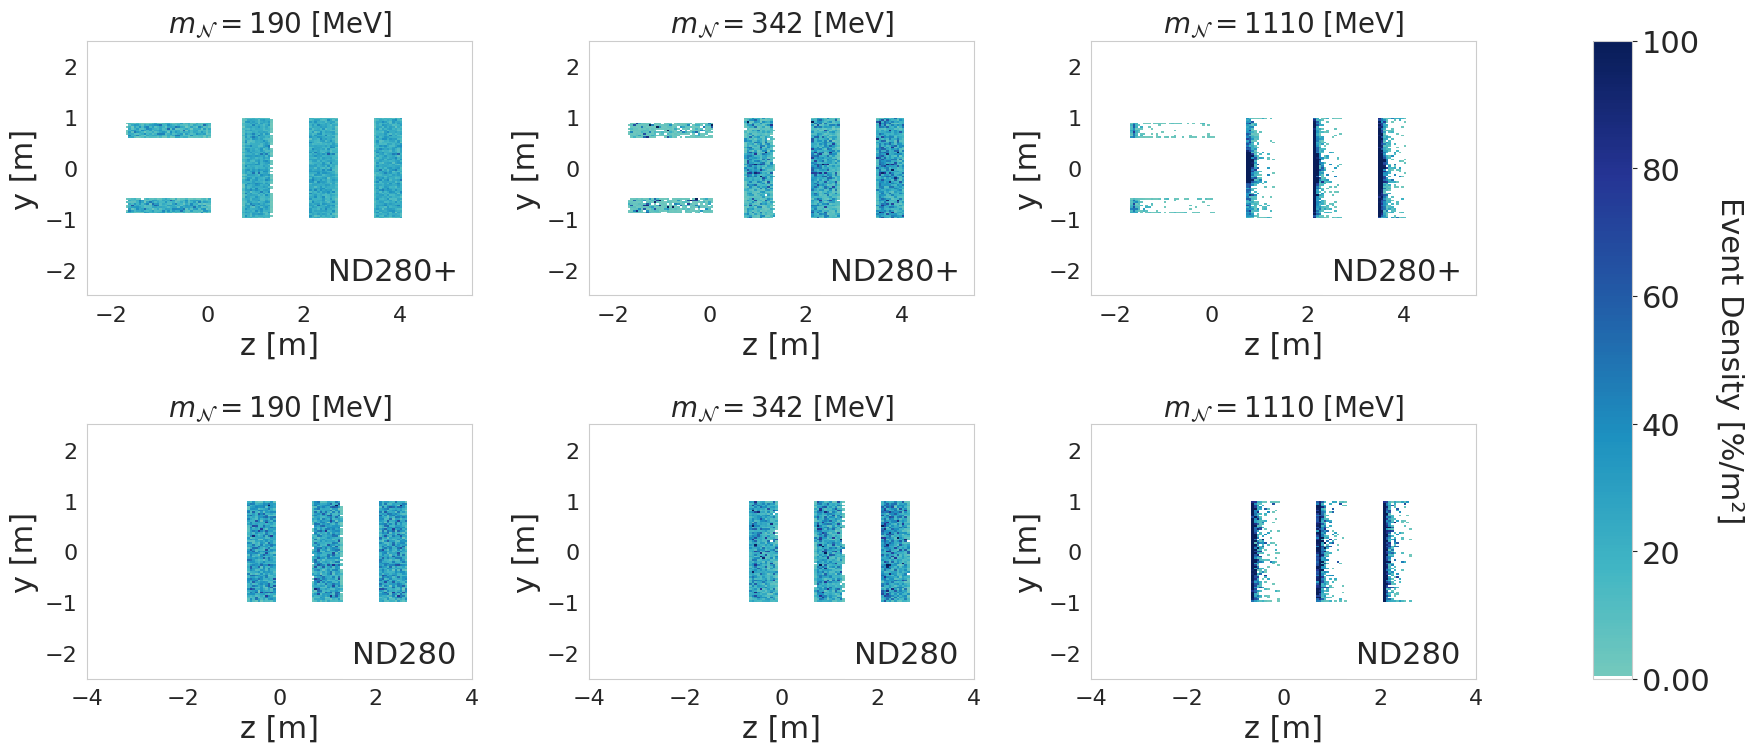

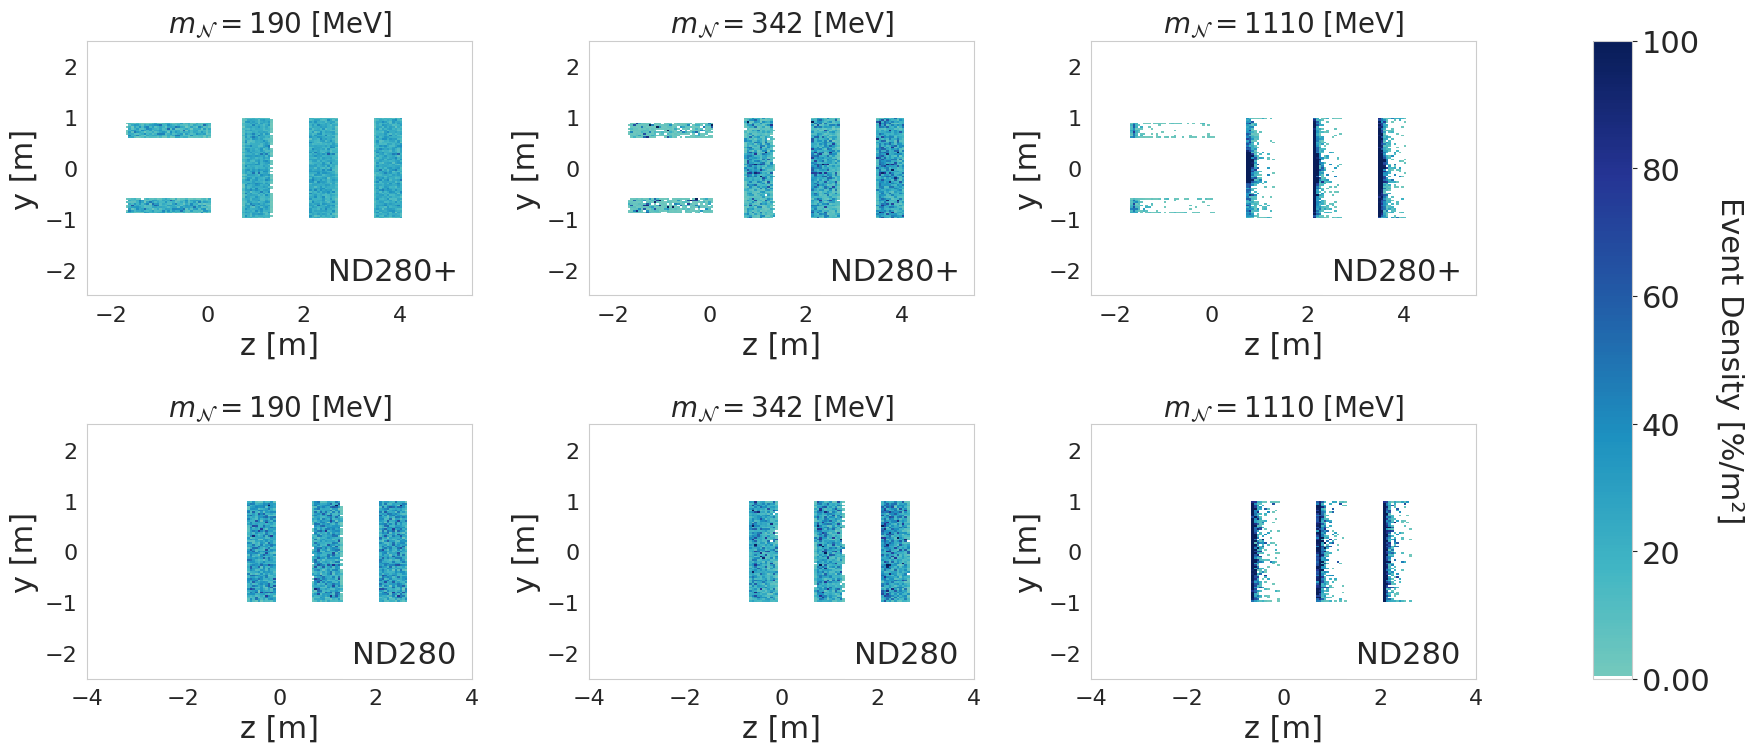

In [81]:
import os
import awkward as awk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

plt.rcParams.update({'font.size': 22})

# Create custom colormap with white for low values
ylgnbu = cm.get_cmap('YlGnBu')
truncated_range = np.linspace(0.4, 1, 204)  # Start at 40% to avoid brightest colors
colors = ['white']  # Start with white
colors.extend(ylgnbu(truncated_range))  # Add the truncated YlGnBu colors
custom_cmap = ListedColormap(colors)

def position_plot(idx, ax, z_pos, y_pos, bins, labelx, labely, title, weights=None, fid_flag=False):
    if weights is None:
        weights = np.ones_like(z_pos)
    
    # Normalize weights to percentage
    weights = (weights / np.sum(weights)) * 100
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(z_pos, y_pos, bins=bins, weights=weights)
    
    # Normalize by bin area for proper density
    bin_area = (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
    hist = hist / bin_area
    
    # Plot with improved colormap and scaling
    pcm = ax.pcolormesh(xedges, yedges, hist.T,
                        cmap=custom_cmap,
                        shading='auto',
                        vmin=0,  # Set minimum to 0
                        vmax=100)  # Adjust this value based on your data
    
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(title, fontsize=20)
    
    # Add detector label with improved positioning
    box_move = 4.5 if fid_flag else 0
    ax.text(-2+box_move if idx<=2 else -3+box_move, -2.2, 
            'ND280+' if idx<=2 else 'ND280',
            bbox=dict(alpha=0.9, facecolor='white', lw=5))
    
    return pcm

def plot_grid_positions(i_values, m_sample, mu_sample, output_dir=None, weighted=False, fid_flag=False, dim='yz'):
    fig = plt.figure(figsize=(18, 8))
    gs = GridSpec(2, 4, figure=fig, width_ratios=[1, 1, 1, 0.1])
    axes = []
    
    for row in range(2):
        for col in range(3):
            axes.append(fig.add_subplot(gs[row, col]))
    
    cbar_ax = fig.add_subplot(gs[:, -1])
    
    # Common ranges and bins
    xrange = [-5, 5]
    yrange = [-2.5, 2.5]
    zrange_ = [-2.5, 5.5]  # for ND280+
    zrange = [-4, 4]      # for ND280
    binnum = 150
    
    # Determine dimensions based on dim parameter
    if 'z' in dim:
        dim1 = 2
        dim2 = 1 if 'y' in dim else 0
        xlabel = "z [m]"
        ylabel = "y [m]" if 'y' in dim else "x [m]"
    else:
        dim1 = 0
        dim2 = 1
        xlabel = "x [m]"
        ylabel = "y [m]"
    
    pcm = None
    
    for idx, (ax, i) in enumerate(zip(axes, i_values)):
        if idx <= 2:
            bins = [np.linspace(zrange_[0], zrange_[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum)]
            detectors = ['ND280UPGRD','TPC2','TPC3','TPC4','TPC5']
        else:
            bins = [np.linspace(zrange[0], zrange[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum)]
            detectors = ['OGTPC1', 'OGTPC2', 'OGTPC3']
        
        m4, tr4 = m_sample[i], mu_sample[i]
        z_pos, y_pos, weights = [], [], []
        
        for detector in detectors:
            path = detector + f"_Dipole_M{m4:2.2e}_mu{tr4:2.2e}_example.parquet"
            
            if os.path.isfile('../MC/output_nu_NEW/' + path):
                print(f"Processing i={i} for {detector}: {path}")
                data = awk.from_parquet("../MC/output_nu_NEW/" + path)
                
                dec_flag = data["primary_type"] == 5914
                fiducial_mask = data["in_fiducial"][:,1]
                
                if fid_flag:
                    z_temp = np.array(data["vertex"][fiducial_mask][:, 1, dim1])
                    y_temp = np.array(data["vertex"][fiducial_mask][:, 1, dim2])
                    if weighted:
                        w_temp = np.array(data['event_weight'][fiducial_mask])
                    else:
                        w_temp = np.ones_like(z_temp)
                else:
                    non_decay_mask = ~dec_flag & fiducial_mask
                    z_temp = np.array(data["vertex"][non_decay_mask][:, 1, dim1])
                    y_temp = np.array(data["vertex"][non_decay_mask][:, 1, dim2])
                    if weighted:
                        w_temp = np.array(data['event_weight'][non_decay_mask])
                    else:
                        w_temp = np.ones_like(z_temp)
                
                z_pos = np.append(z_pos, z_temp)
                y_pos = np.append(y_pos, y_temp)
                weights = np.append(weights, w_temp)
        
        pcm = position_plot(idx, ax, z_pos, y_pos, bins,
                          xlabel, ylabel,
                          r'$m_{\mathcal{N}} = $'+f"{m4*1000:3.0f} [MeV]",
                          weights=weights, fid_flag=fid_flag)
    
    # Add colorbar with improved formatting
    if pcm is not None:
        cbar = plt.colorbar(pcm, cax=cbar_ax)
        cbar.set_ticks([0, 20,40,60,80])
        cbar.set_ticklabels(['0', '20', '40', '60', '80', '100'])
        cbar.ax.set_ylabel('Event Density [%/m²]', rotation=270, labelpad=25)
    
    plt.tight_layout()
    
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f'event_density_grid_{dim}.pdf')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")
    
    plt.show()
    return fig

# Example usage:
i_values = [45,46,48,45,46,48]
output_dir = './figures'
plot_grid_positions(i_values, m_sample, mu_sample, output_dir=output_dir, weighted=True, fid_flag=True, dim='yz')

/tmp/ipykernel_2036796/244107282.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ylgnbu = cm.get_cmap('YlGnBu')
/tmp/ipykernel_2036796/244107282.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds = cm.get_cmap('YlOrBr')


Saved figure to ./figures/overlaid_density_grid.pdf


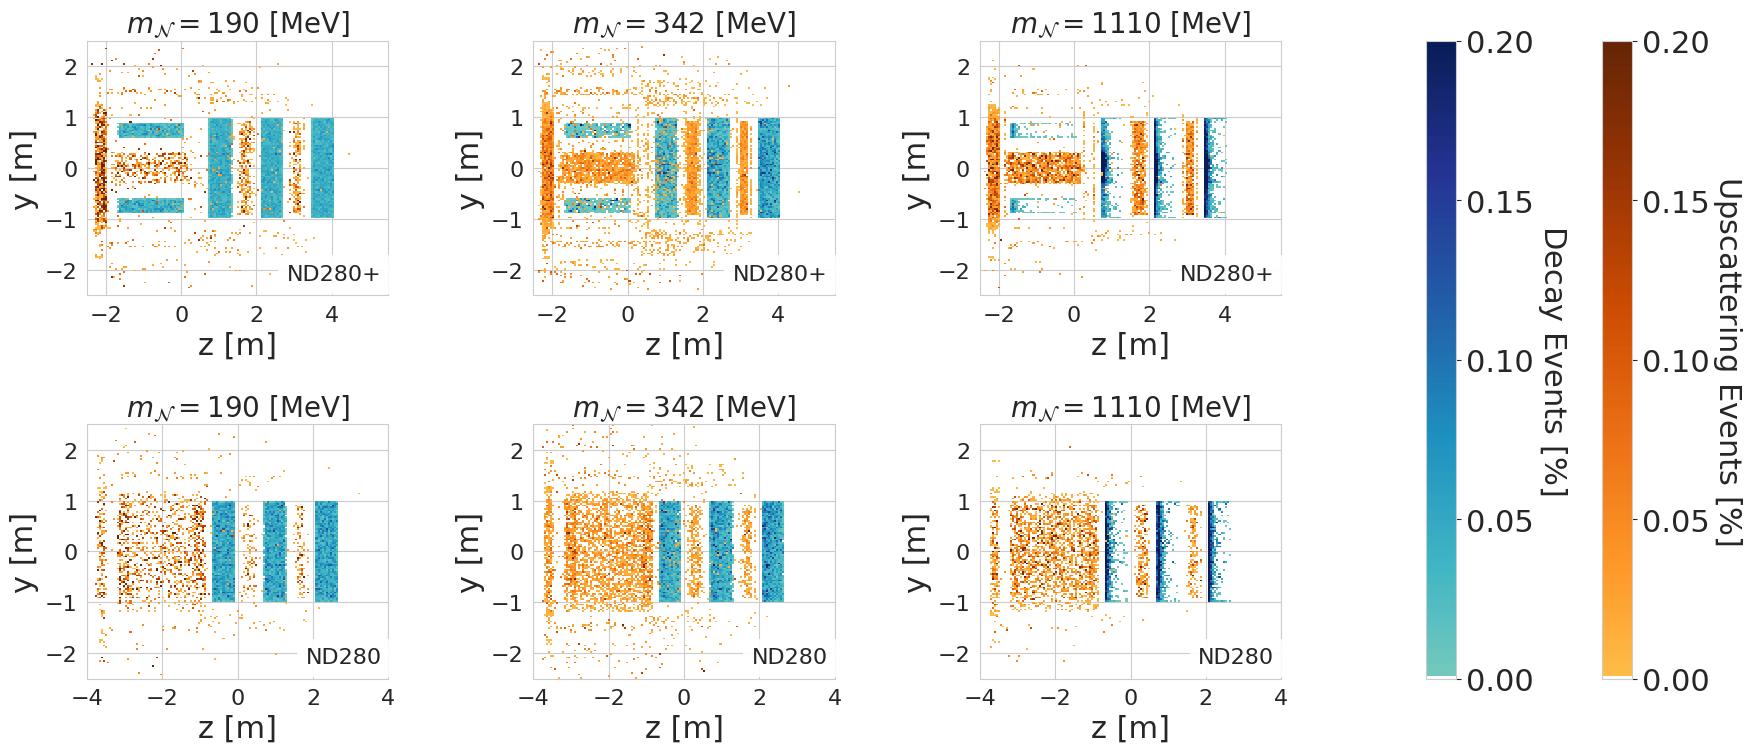

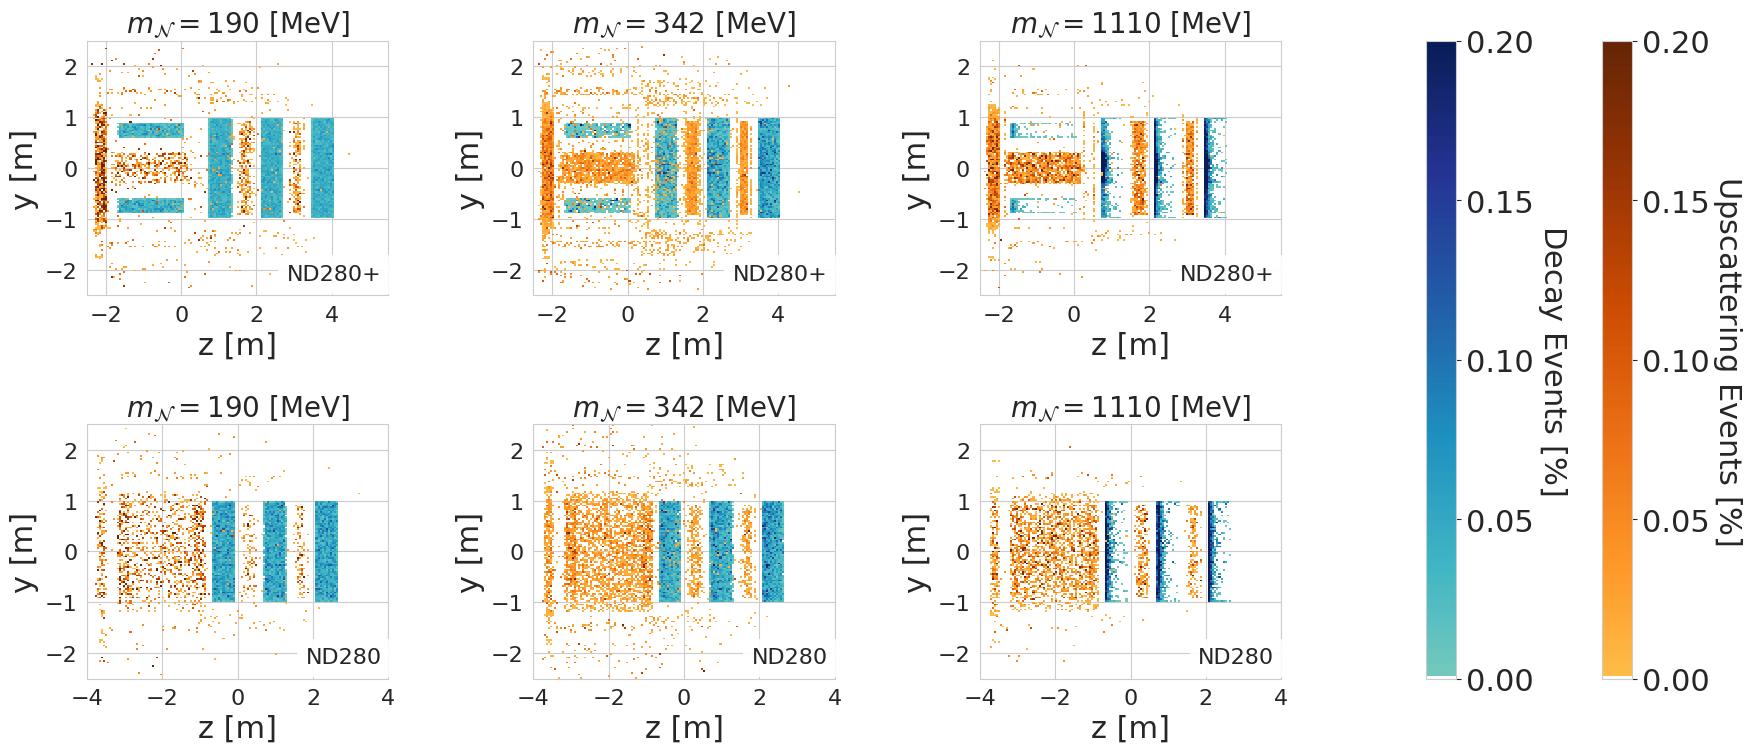

In [16]:
import os
import awkward as awk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

plt.rcParams.update({'font.size': 22})

# Create two different colormaps for the two plots with transparency
ylgnbu = cm.get_cmap('YlGnBu')
truncated_range = np.linspace(0.4, 1, 204)
colors1 = np.zeros((205, 4))  # RGBA array with transparency
colors1[0] = [0, 0, 0, 0]  # Transparent for lowest value
colors1[1:] = ylgnbu(truncated_range)  # Add the YlGnBu colors
custom_cmap1 = ListedColormap(colors1)

# Second colormap with transparency
reds = cm.get_cmap('YlOrBr')
colors2 = np.zeros((205, 4))  # RGBA array with transparency
colors2[0] = [0, 0, 0, 0]  # Transparent for lowest value
colors2[1:] = reds(truncated_range)  # Add the Reds colors
custom_cmap2 = ListedColormap(colors2)

def plot_combined_positions(i_values, m_sample, mu_sample, output_dir=None, weighted=False, fid_flag=False):
    # Create figure with 2x4 grid (including colorbar space)
    fig = plt.figure(figsize=(18, 8))
    gs = GridSpec(2, 5, figure=fig, width_ratios=[1, 1, 1, 0.1, 0.1])
    axes = []
    vrange = [0,0.2]
    
    # Create subplots
    for row in range(2):
        for col in range(3):
            axes.append(fig.add_subplot(gs[row, col]))
    
    # Create two colorbar axes
    cbar_ax1 = fig.add_subplot(gs[:, 3])
    cbar_ax2 = fig.add_subplot(gs[:, 4])
    
    # Common ranges and bins
    xrange = [-5, 5]
    yrange = [-2.5, 2.5]
    zrange_ = [-2.5, 5.5]
    zrange = [-4, 4]
    binnum = 150
    
    pcm1, pcm2 = None, None
    
    for idx, (ax, i) in enumerate(zip(axes, i_values)):
        if idx <= 2:
            bins = (np.linspace(zrange_[0], zrange_[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum))
        else:
            bins = (np.linspace(zrange[0], zrange[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum))
        
        m4, tr4 = m_sample[i], mu_sample[i]
        
        # Plot A - Multiple detectors
        detectors = ['ND280UPGRD','TPC2','TPC3','TPC4','TPC5'] if idx <= 2 else ['OGTPC1', 'OGTPC2', 'OGTPC3']
        z_pos_A, y_pos_A, weights_A = [], [], []
        
        for detector in detectors:
            path = detector + f"_Dipole_M{m4:2.2e}_mu{tr4:2.2e}_example.parquet"
            if os.path.isfile('../MC/output_nu_NEW/' + path):
                data = awk.from_parquet("../MC/output_nu_NEW/" + path)
                fiducial_mask = data["in_fiducial"][:,1]
                
                if fid_flag:
                    z_temp = np.array(data["vertex"][fiducial_mask][:, 1, 2])
                    y_temp = np.array(data["vertex"][fiducial_mask][:, 1, 1])
                    if weighted:
                        w_temp = np.array(data['event_weight'][fiducial_mask])
                else:
                    dec_flag = data["primary_type"] == 5914
                    non_decay_mask = ~dec_flag & fiducial_mask
                    z_temp = np.array(data["vertex"][non_decay_mask][:, 1, 2])
                    y_temp = np.array(data["vertex"][non_decay_mask][:, 1, 1])
                    if weighted:
                        w_temp = np.array(data['event_weight'][non_decay_mask])
                    else:
                        w_temp = np.ones_like(z_temp)
                
                z_pos_A = np.append(z_pos_A, z_temp)
                y_pos_A = np.append(y_pos_A, y_temp)
                weights_A = np.append(weights_A, w_temp)
        
        if weighted:
            weights_A = weights_A / np.sum(weights_A) * 100
        
        # Plot first histogram with some transparency
        hist_A, xedges, yedges = np.histogram2d(z_pos_A, y_pos_A, bins=bins, weights=weights_A, density=True)
        bin_area = (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
        hist_A = hist_A / np.sum(hist_A) * 100
        
        pcm1 = ax.pcolormesh(xedges, yedges, hist_A.T,
                            cmap=custom_cmap1,
                            # Transparency handled by colormap
                            vmin=vrange[0], vmax=vrange[1])
        
        # Plot B - Single detector
        detector = 'TPC5' if idx <= 2 else 'OGTPC3'
        path = detector + f"_Dipole_M{m4:2.2e}_mu{tr4:2.2e}_example.parquet"
        
        if os.path.isfile('../MC/output_nu_NEW/' + path):
            data = awk.from_parquet("../MC/output_nu_NEW/" + path)
            
            if fid_flag:
                z_pos = np.array(data["vertex"][data["in_fiducial"][:,1]][:, 0, 2])
                y_pos = np.array(data["vertex"][data["in_fiducial"][:,1]][:, 0, 1])
                if weighted:
                    weights = np.array(data['event_weight'][data["in_fiducial"][:,1]])
                    weights = weights / np.sum(weights) * 100
            else:
                dec_flag = data["primary_type"] == 5914
                z_pos = np.array(data["vertex"][~dec_flag][:, 0, 2])
                y_pos = np.array(data["vertex"][~dec_flag][:, 0, 1])
                if weighted:
                    weights = np.array(data['event_weight'])
                    weights = weights / np.sum(weights) * 100
                else:
                    weights = None
            
            hist_B, _, _ = np.histogram2d(z_pos, y_pos, bins=bins, weights=weights, density=True)
            hist_B = hist_B / np.sum(hist_B) * 100
            
            pcm2 = ax.pcolormesh(xedges, yedges, hist_B.T,
                                cmap=custom_cmap2,
                                # Transparency handled by colormap
                                vmin=vrange[0], vmax=vrange[1])
        
        ax.set_xlabel("z [m]")
        ax.set_ylabel("y [m]")
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(r'$m_{\mathcal{N}} = $'+f"{m4*1000:3.0f} [MeV]", fontsize=20)
        
        box_move = 4.5 if fid_flag else 0
        ax.text(-1.7+box_move if idx<=2 else -2.7+box_move, -2.2, 
                'ND280+' if idx<=2 else 'ND280',fontsize=16,
                bbox=dict(alpha=0.9, facecolor='white', lw=5, ))
    
    # Add colorbars
    if pcm1 is not None:
        cbar1 = plt.colorbar(pcm1, cax=cbar_ax1)
        cbar1.set_ticks([0,0.05,0.1,0.15,0.2])
        # Optionally customize the labels
        cbar1.set_ticklabels(['0.00','0.05','0.10','0.15','0.20'])
        cbar1.ax.set_ylabel(r'Decay Events [$\%$]', rotation=270, labelpad=25)
    
    if pcm2 is not None:
        cbar2 = plt.colorbar(pcm2, cax=cbar_ax2)
        cbar2.set_ticks([0,0.05,0.1,0.15,0.2])
        # Optionally customize the labels
        cbar2.set_ticklabels(['0.00','0.05','0.10','0.15','0.20'])
        cbar2.ax.set_ylabel(r'Upscattering Events [$\%$]', rotation=270, labelpad=25)
    
    plt.tight_layout()
    
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, 'overlaid_density_grid.pdf')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")
    
    plt.show()
    return fig

# Example usage:
i_values = [45,46,48,45,46,48]
output_dir = './figures'
plot_combined_positions(i_values, m_sample, mu_sample, output_dir=output_dir, weighted=True, fid_flag=True)

Processing i=62 for TPC4: TPC4_Dipole_M3.25e-02_mu2.15e-06_example.parquet
Processing i=45 for TPC4: TPC4_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=77 for TPC4: TPC4_Dipole_M6.16e-01_mu3.59e-06_example.parquet
Processing i=62 for OGTPC1: OGTPC1_Dipole_M3.25e-02_mu2.15e-06_example.parquet
Processing i=45 for OGTPC1: OGTPC1_Dipole_M1.90e-01_mu7.74e-07_example.parquet
Processing i=77 for OGTPC1: OGTPC1_Dipole_M6.16e-01_mu3.59e-06_example.parquet


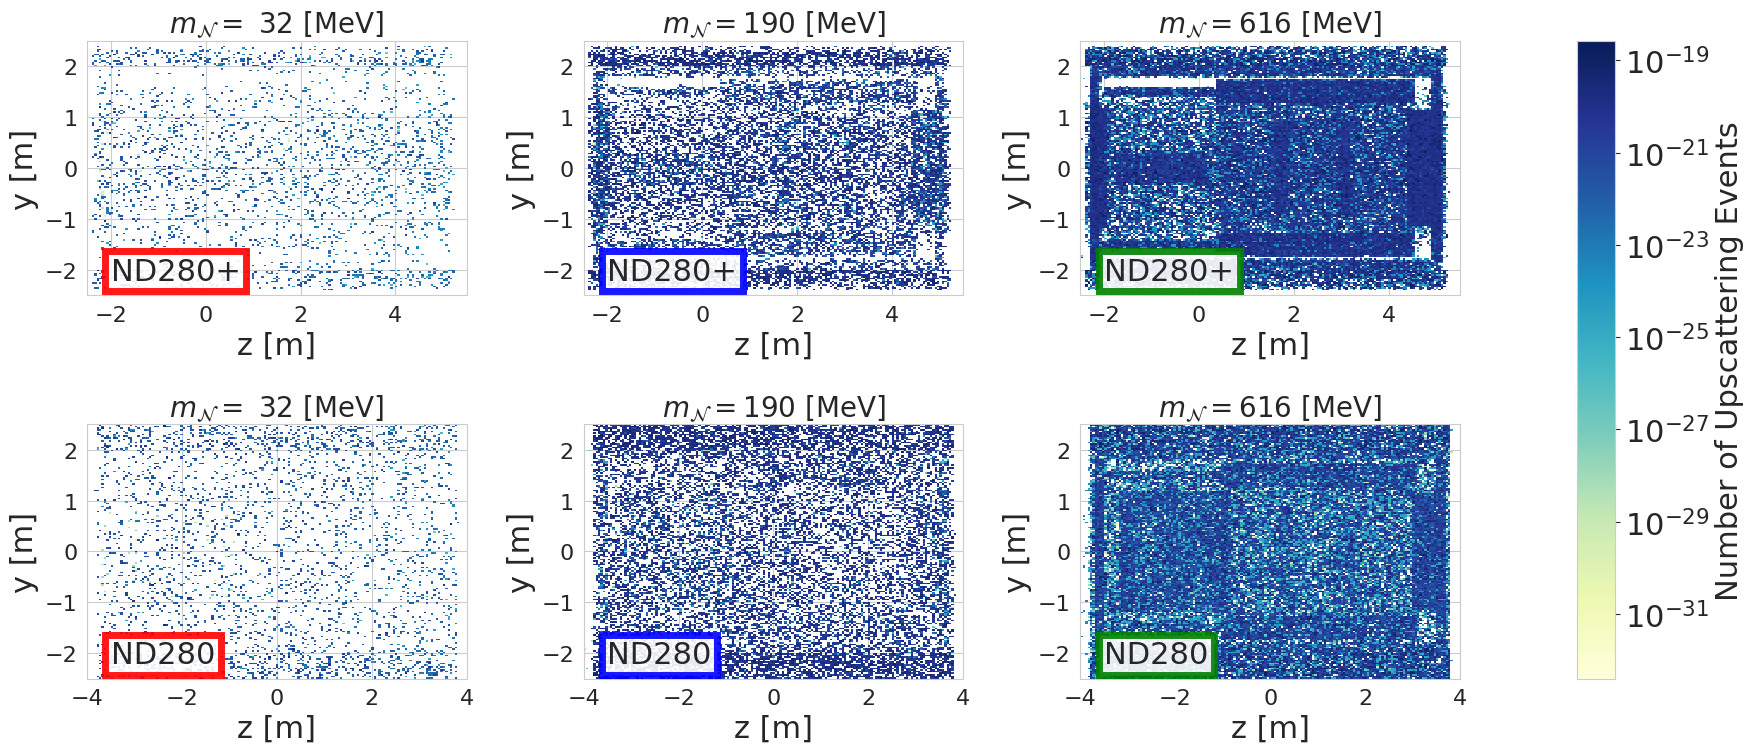

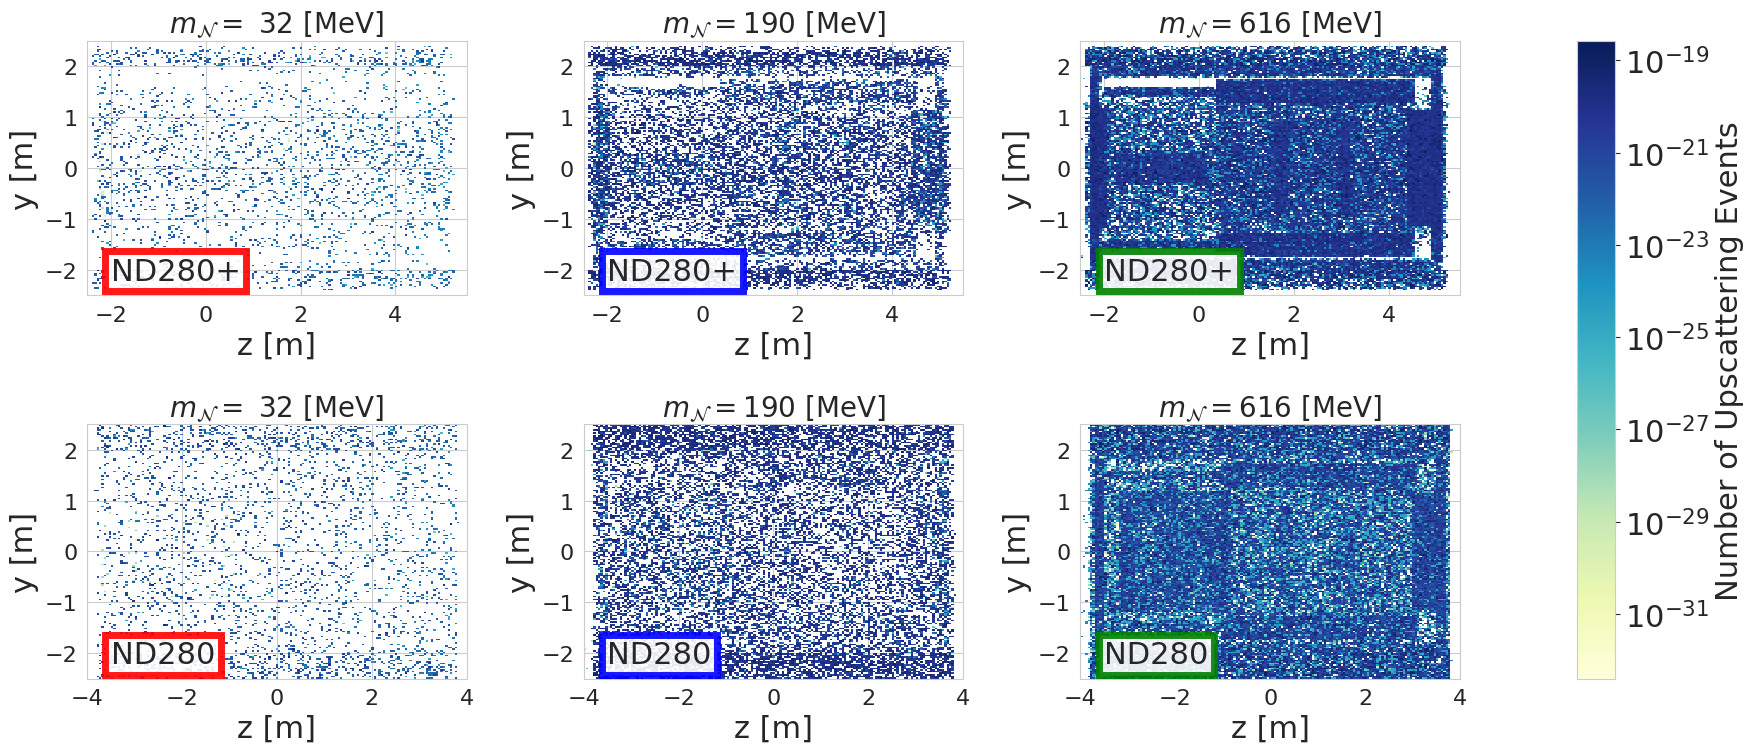

In [ ]:
i_values = [62,45,77,62,45,77]
output_dir = './figures'
plot_grid_positions(i_values, m_sample, mu_sample, output_dir=None, weighted=True)

In [ ]:
import imageio.v2 as imageio
from io import BytesIO

def decay_position_plot(idx, ax, x, y, bins, labelx, labely, title, weights=None):
    pcm = ax.hist2d(x, y, bins=bins, norm=LogNorm(), weights=weights,range=[[-100, 3], [-3, 3]])
    ax.set_xlabel(labelx, fontsize=16)
    ax.set_ylabel(labely, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(title, fontsize=20)
    ax.set_xlim(-100, 3)  # Match the histogram range
    ax.set_ylim(-3, 3)
    return pcm

# List to store images
images = []
exp='OGTPC3'

# Create plots and save them as images
for i in [87,88]:
    path = f"{exp}_Dipole_M{m_sample[i]:2.2e}_mu{mu_sample[i]:2.2e}_example.parquet"
    if os.path.isfile('../MC/output_nu_NewVol_V2/' + path):
        print(f"Processing i={i} for TPC4: {path}")
        data = awk.from_parquet("../MC/output_nu_NewVol_V2/" + path)
        mask = data['vertex'][:,0,2]<-10

        fig, ax = plt.subplots(figsize=(12, 3))
        decay_position_plot(1, ax,
                          np.array(data["vertex"][data["in_fiducial"][:,1]*mask][:, 0, 2]),
                          np.array(data["vertex"][data["in_fiducial"][:,1]*mask][:, 0, 1]),
                          bins=150, labelx="z [m]", labely="y [m]",
                          title=r'$m_{\mathcal{N}} = $'+f"{m_sample[i]*1000:3.0f} [MeV]"+r', $\mu = $'+f"{mu_sample[i]:3.1e} [GeV]",
                          weights=np.array(data['event_weight'][data["in_fiducial"][:,1]*mask]))
        plt.tight_layout()
        
        # Save plot to a bytes buffer
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        images.append(imageio.imread(buf))
        plt.close()
        buf.close()

# Save as GIF
imageio.mimsave('decay_positions.gif', images, duration=2)  # duration is in seconds per frame

Processing i=87 for TPC4: OGTPC3_Dipole_M6.16e-01_mu5.99e-06_example.parquet
Processing i=88 for TPC4: OGTPC3_Dipole_M1.11e+00_mu5.99e-06_example.parquet


In [ ]:
weighted_med = {}
m4 = m_sample[87]
tr4 = mu_sample[87]
base_path = '../MC/output_nu_NewVol_V2/'

path = f"{base_path}TPC5_Dipole_M{m4:.2e}_mu{tr4:.2e}_example.parquet"
if os.path.isfile(path):
    data = ak.from_parquet(path)
    weight = ak.to_numpy(data['event_weight'])
    vertex = ak.to_numpy(data['vertex'])
    dist = np.linalg.norm(vertex[:, 0] - vertex[:, 1], axis=1)
    weighted_med[(m4, tr4)] = weighted_median(dist, weight)


In [47]:
np.sum(data['vertex'][:,1,2] < -10)

0

In [66]:
import multiprocessing
import awkward as ak
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from tqdm.auto import tqdm
import os
import csv
from dataclasses import dataclass
from typing import Tuple, Optional, NamedTuple, List, Union
from pathlib import Path

@dataclass
class Constants:
    ELECTRON_MASS = 0.511e-3  # GeV/c^2
    DEFAULT_TARGET_SUM = 1e5
    DATA_DIR = Path('../output_nubar_NewVol_V2')

class ParticleData(NamedTuple):
    """Container for particle-related data"""
    weights: np.ndarray
    nuout_momenta: np.ndarray
    N_momenta: np.ndarray
    gamma_ETotal: np.ndarray
    gamma_direction: np.ndarray

def create_efficiency_interpolator(
    filename: str = "kaon_decay_efficiency_data.txt",
    skip_rows: int = 2,
    m_n_min: float = 10,
    m_n_max: float = 2000,
    m_n_step: float = 25
) -> interp1d:
    """Create an interpolation function for minimum efficiency."""
    m_n, mu_decay, e_decay = np.loadtxt(filename, skiprows=skip_rows, usecols=(0, 1, 2), unpack=True)
    min_decay = np.minimum(mu_decay, e_decay)
    extended_m_n = np.arange(m_n_min, m_n_max + m_n_step, m_n_step)
    
    # Interpolate values
    extended_min = np.interp(extended_m_n, m_n, min_decay)
    return interp1d(extended_m_n, extended_min, kind='linear', bounds_error=False, fill_value='extrapolate')

def normalize_vectors(vectors: np.ndarray) -> np.ndarray:
    """Normalize vectors efficiently handling zero magnitudes."""
    # Handle zero magnitudes
    magnitudes = np.linalg.norm(vectors, axis=1)
    non_zero = magnitudes != 0
    normalized = np.zeros_like(vectors)
    normalized[non_zero] = vectors[non_zero] / magnitudes[non_zero, np.newaxis]
    return normalized

def process_particle_data(data: ak.Array, type_key: str, type_value: int, momentum_key: str) -> np.ndarray:
    """Process particle data based on type and momentum keys."""
    flag = data[type_key] == type_value
    momenta = data[momentum_key][flag]
    valid_momenta = ak.mask(momenta, ak.num(momenta, axis=2) > 0)
    converted_momenta = ak.to_numpy(valid_momenta[~ak.is_none(valid_momenta, axis=1)])
    return np.squeeze(converted_momenta)

def load_data(exp: str, m: float, mu: float, POT: float) -> Optional[ParticleData]:
    """Load and process particle data from parquet file."""
    path = Constants.DATA_DIR / f"{exp}_Dipole_M{m:2.2e}_mu{mu:2.2e}_example.parquet"
    
    try:
        if not path.exists():
            print(f'File {path} not found.')
            return None
            
        data = ak.from_parquet(str(path))
        
        # Apply masks and filters
        mask = ak.to_numpy(data['vertex'][:, 0, 2] < -10)
        dec_flag = ak.to_numpy(data["primary_type"] == 5914)
        fid_flag = ak.to_numpy(data["in_fiducial"][dec_flag]) * mask
        
        # Convert to numpy arrays
        weights = ak.to_numpy(data['event_weight']) * fid_flag * POT
        weights = np.squeeze(weights)
        
        # Process particle data
        N_momenta = ak.to_numpy(data["primary_momentum"][data["primary_type"] == 5914])
        N_momenta = np.squeeze(N_momenta)
        
        # Process gamma data
        gamma_momenta = process_particle_data(data, "secondary_types", 22, "secondary_momenta")
        if len(gamma_momenta) == 0:
            return None
            
        gamma_ETotal = gamma_momenta[:, 0]
        gamma_direction = normalize_vectors(gamma_momenta[:, 1:])
        
        nuout_momenta = process_particle_data(data, "secondary_types", 5910, "secondary_momenta")
        
        return ParticleData(
            weights=weights,
            nuout_momenta=nuout_momenta,
            N_momenta=N_momenta,
            gamma_ETotal=gamma_ETotal,
            gamma_direction=gamma_direction
        )
        
    except Exception as e:
        print(f'Error processing file {path}: {str(e)}')
        return None

def apply_cuts(particle_data: ParticleData) -> np.ndarray:
    """Apply physics cuts to the data."""
    if len(particle_data.N_momenta) == 0 or len(particle_data.gamma_ETotal) == 0:
        return np.array([])
        
    momentum_cut = particle_data.N_momenta[:, 3] / np.linalg.norm(particle_data.N_momenta[:, 1:], axis=1) > 0.999
    energy_cut = particle_data.gamma_ETotal > 2 * Constants.ELECTRON_MASS
    return particle_data.weights * momentum_cut * energy_cut

def write_signal_strength(
    exp: str,
    i: int,
    m: float,
    mu: float,
    signal_strength: float,
    filename='nobump_.csv'
) -> None:
    # Check if the file exists to determine if we need to write the header
    file_exists = os.path.isfile(filename)
    
    # Open the file in append mode
    with open(filename, "a", newline='') as f:
        writer = csv.writer(f)
        
        if not file_exists:
            writer.writerow(["Experiment", "i", "Mass", "Coupling", "Signal_Strength"])

        writer.writerow([exp,f"{i}",f"{m:.6e}",f"{mu:.6e}",f"{signal_strength:.32f}"])

def process_experiment(args: Tuple) -> None:
    """Process a single experiment with given parameters."""
    exp, i, m, mu, POT = args
    print(f'Processing: {exp}, HNL mass {m} GeV, Dipole Strength mu {mu}')
    
    # Load and process data
    particle_data = load_data(exp, m, mu, POT)
    if particle_data is None or np.sum(particle_data.weights) == 0:
        signal_strength = 0
    else:
        weights = apply_cuts(particle_data)
        if len(weights) == 0:
            signal_strength = 0
        else:
            signal_strength = get_min_efficiency(m * 1000) * np.sum(weights)
            print(f"Final Signal Strength: {signal_strength:.1f}")
    
    # Write results to CSV
    print(signal_strength)


get_min_efficiency = create_efficiency_interpolator()

# Initialize parameters
n_m, n_mu = 10, 10
m_sample = np.geomspace(1e-2, 2, n_m)
mu_sample = np.geomspace(1e-7, 1e-5, n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = m_sample.ravel()
mu_sample = mu_sample.ravel()

exp = 'OGTPC3'
index = 87

process_experiment((exp,index,m_sample[87],mu_sample[87],1e21))



Processing: OGTPC3, HNL mass 0.6161550277583343 GeV, Dipole Strength mu 5.994842503189409e-06
0


Processing ../MC/for_plot/OGTPC3_Dipole_M6.16e-01_mu5.99e-06_example.parquet
Processing ../MC/for_plot/TPC5_Dipole_M6.16e-01_mu5.99e-06_example.parquet


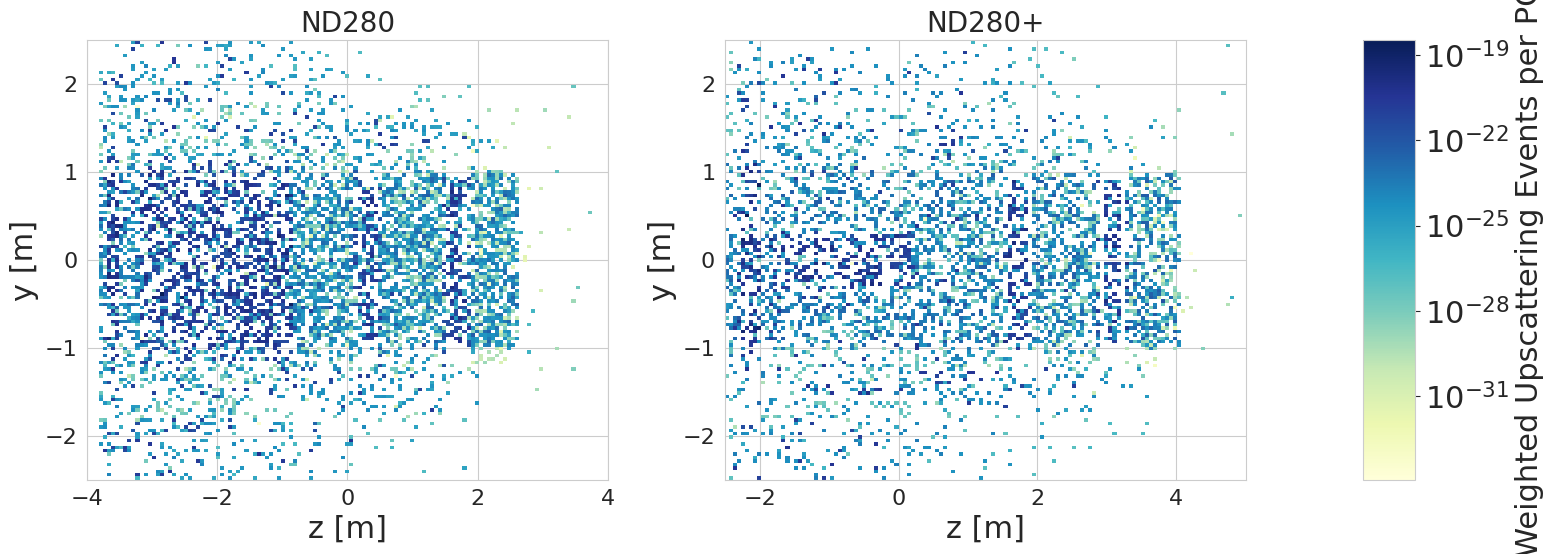

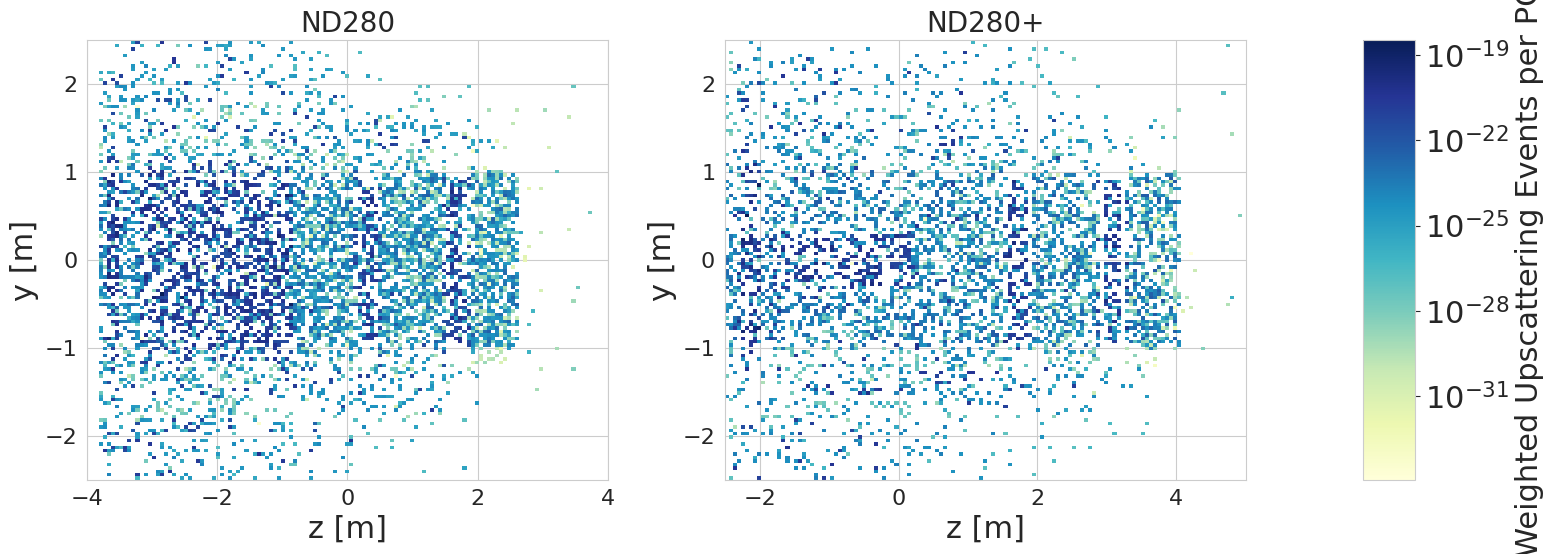

In [10]:
import os
import awkward as awk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

plt.rcParams.update({'font.size': 22, 'image.cmap': 'YlGnBu'})

bboxcls=['red','blue','green']
def position_plot(idx, ax, x, y, bins, labelx, labely, title, weights=None, fid_flag=False):
    pcm = ax.hist2d(x, y, bins=bins, norm=LogNorm(), weights=weights)
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(title, fontsize=20)
    box_move = 4.5 if fid_flag else 0
    return pcm

def plot_grid_positions(path1, path2, output_dir=None, weighted=False, fid_flag=False):
    # Create figure with 2x3 grid, with extra space for colorbar
    fig = plt.figure(figsize=(16, 6))  # Adjusted for landscape orientation
    
    # Create GridSpec with space for colorbar
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 0.1])
    axes = []
    paths = [path1, path2]
    # Create all subplots
    for row in range(1):
        for col in range(2):
            axes.append(fig.add_subplot(gs[row, col]))
    
    # Create colorbar axis
    cbar_ax = fig.add_subplot(gs[:, -1])
    
    # Common ranges and bins
    xrange = [-5, 5]
    yrange = [-2.5, 2.5]
    zrange_ = [-2.5, 5]
    zrange = [-4, 4]
    binnum = 130
    
    pcm = None  # Store the last plot for colorbar
    
    # Plot each subplot
    for idx, (ax, path) in enumerate(zip(axes, paths)):
        if idx:
            bins = (np.linspace(zrange_[0], zrange_[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum))
        else:
            bins = (np.linspace(zrange[0], zrange[1], binnum),
                   np.linspace(yrange[0], yrange[1], binnum))
                
        # Determine which detector to use based on column (even/odd index)
        
        if os.path.isfile(path):
            print(f"Processing {path}")
            data = awk.from_parquet(path)
            
            # Get vertex positions
            dec_flag = data["primary_type"] == 5914
            if fid_flag:
                z_pos = np.array(data["vertex"][data["in_fiducial"][:,1]][:, 0, 2])  # z-axis
                y_pos = np.array(data["vertex"][data["in_fiducial"][:,1]][:, 0, 1])  # y-axis
                
                weights = np.array(data['event_weight'][data["in_fiducial"][:,1]]) if weighted else None

            else:
                z_pos = np.array(data["vertex"][~dec_flag][:, 0, 2])  # z-axis
                y_pos = np.array(data["vertex"][~dec_flag][:, 0, 1])  # y-axis
            
                # Get weights if weighted
                weights = np.array(data['event_weight']) if weighted else None
            
            # Create plot
            pcm = position_plot(idx, ax, z_pos, y_pos, bins,
                              "z [m]", "y [m]",
                              'ND280+' if idx else 'ND280', weights=weights, fid_flag=fid_flag)
    
    # Add colorbar
    if pcm is not None:
        plt.colorbar(pcm[3], cax=cbar_ax, label="Weighted Upscattering Events per POT")
    
    plt.tight_layout()
    
    # Handle file saving
    if output_dir is not None:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, 'event_density_grid.pdf')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")
    
    plt.show()
    return fig

# Example usage:
path1 = '../MC/for_plot/OGTPC3_Dipole_M6.16e-01_mu5.99e-06_example.parquet'
path2 = '../MC/for_plot/TPC5_Dipole_M6.16e-01_mu5.99e-06_example.parquet'
plot_grid_positions(path1, path2, output_dir=None, weighted=True, fid_flag=True)

In [3]:
data = awk.from_parquet('/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/Dipole-HNL-T2K/e+e-/output/TPC5_Dipole_M1.00e-02_mu1.00e-07_example.parquet')
data2body = awk.from_parquet('../MC/for_plot/OGTPC3_Dipole_M6.16e-01_mu5.99e-06_example.parquet')

In [ ]:
data['secondary_momenta'][0][0]

<Array [[0.378, -0.000403, ..., 0.378], [...]] type='2 * var * float64'>

In [35]:
data['primary_momentum'][0]

<Array [[0.378, 0, 0, 0.378], [0.378, ...]] type='2 * var * float64'>

In [40]:
data['num_secondaries']


<Array [[2, 3], [2, 3], [...], ..., [2, 3], [2, 3]] type='100000 * var * int64'>

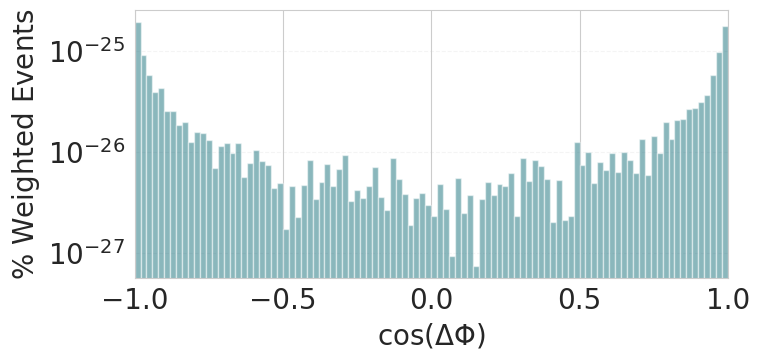

In [37]:
plt.rcParams.update({'font.size': 20, 'image.cmap': 'YlGnBu'})

data = awk.from_parquet('/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/Dipole-HNL-T2K/e+e-/output/OGTPC3_Dipole_M1.05e-01_mu1.00e-07_example.parquet')

em_mtm = data['secondary_momenta'][:,1,:,1]
ep_mtm = data['secondary_momenta'][:,1,:,2]
weight = data['event_weight']*data['in_fiducial'][:,1]
weight = np.nan_to_num(weight, nan=0)
weight = weight

def calculate_cos(em_mtm, ep_mtm):
    dot_products = np.einsum('ij,ij->i', em_mtm, ep_mtm)  # Dot products of vectors
    magnitudes_em = np.linalg.norm(em_mtm, axis=1)       # Magnitudes of em_mtm vectors
    magnitudes_ep = np.linalg.norm(ep_mtm, axis=1)       # Magnitudes of ep_mtm vectors

    # Computing the cosine of the angles
    cos_theta = dot_products / (magnitudes_em * magnitudes_ep)

    # Handling potential numerical errors leading to cos_theta > 1 or < -1
    cos_theta = np.clip(cos_theta, -1, 1)

    return cos_theta

costheta = calculate_cos(em_mtm, ep_mtm)

# Plotting the histogram of the costheta
plt.figure(figsize=(8, 4))
plt.hist(costheta, bins=100, color=cls[0], alpha=0.5, weights=weight)
# plt.title(r'ND280 in fid., $m_{\mathcal{N}}=105$ MeV, $\mu_{tr}=1E-7$', fontsize=20)
plt.xlim(-1,1)
plt.yscale('log')
plt.xlabel(r'$\cos(\Delta\Phi)$', fontsize=20)
plt.ylabel(r'$\%$ Weighted Events', fontsize=20)
# plt.text(-0.95,6,'ND280', fontsize=22)

plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig('costheta.pdf')
plt.show()

In [30]:
np.sum(weight[costheta>0])/np.sum(weight)

0.4911155330033165

In [34]:
n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

m,mu,ef = [],[],[]

def calculate_cos(em_mtm, ep_mtm, plot=False):
    dot_products = np.einsum('ij,ij->i', em_mtm, ep_mtm)  # Dot products of vectors
    magnitudes_em = np.linalg.norm(em_mtm, axis=1)       # Magnitudes of em_mtm vectors
    magnitudes_ep = np.linalg.norm(ep_mtm, axis=1)       # Magnitudes of ep_mtm vectors

    # Computing the cosine of the angles
    cos_theta = dot_products / (magnitudes_em * magnitudes_ep)

    # Handling potential numerical errors leading to cos_theta > 1 or < -1
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Plotting the histogram of the angles
    if plot:
        plt.figure(figsize=(8, 6))
        plt.hist(cos_theta, bins=100, color='blue', alpha=0.3)
        # plt.title(r'$m_{\mathcal{N}}=10$ MeV, $\mu_{tr}=1E-7$', fontsize=20)
        plt.xlabel(r'$\cos\theta$', fontsize=20)
        plt.ylabel('Frequency', fontsize=20)
        plt.yscale('log')
        plt.grid(axis='y', linestyle='--', alpha=0.2)
        plt.text(-1,800,'ND280+')
        plt.show()

    return cos_theta

for m4, tr4 in zip(m_sample, mu_sample):
    if os.path.exists(f'../e+e-/output/OGTPC3_Dipole_M{m4:2.2e}_mu{tr4:2.2e}_example.parquet'):
        m.append(m4)
        mu.append(tr4)
        data = awk.from_parquet(f'../e+e-/output/TPC5_Dipole_M{m4:2.2e}_mu{tr4:2.2e}_example.parquet')
        em_mtm = data['secondary_momenta'][:,1,:,1]
        ep_mtm = data['secondary_momenta'][:,1,:,2]
        costheta = np.asarray(calculate_cos(em_mtm, ep_mtm, plot=False))
        ef.append(np.sum(costheta>0))
        


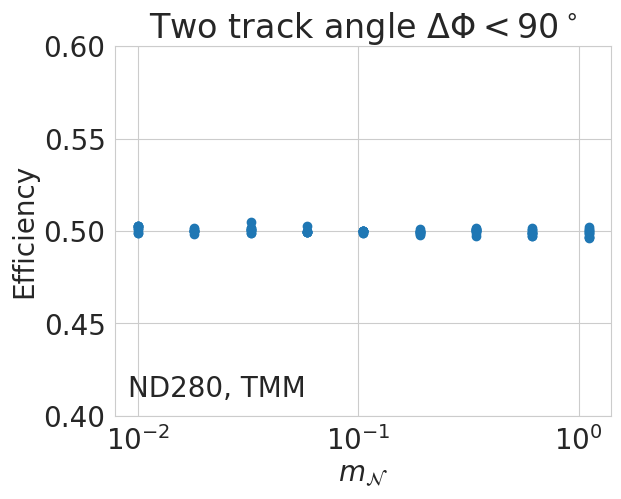

In [64]:
ef = np.asarray(ef)
m = np.asarray(m)
plt.scatter(m,ef/1e5)

plt.title(r'Two track angle $\Delta \Phi<90^\circ$')
plt.ylabel('Efficiency')
plt.ylim(0.4,0.6)
plt.xlabel(r'$m_\mathcal{N}$')
plt.xscale('log')
plt.text(9e-3,0.41,'ND280, TMM')
plt.show()

In [56]:
m

array([0.03245936, 0.10536103, 0.18982351, 0.34199519, 0.61615503,
       1.11009462, 0.01      , 0.01801648, 0.03245936, 0.05848035,
       0.10536103, 0.34199519, 0.61615503, 1.11009462, 0.01      ,
       0.03245936, 0.05848035, 0.10536103, 0.18982351, 0.34199519,
       1.11009462, 0.01      , 0.01801648, 0.03245936, 0.18982351,
       0.34199519, 0.61615503, 1.11009462, 0.01      , 0.01801648,
       0.10536103, 0.18982351, 0.34199519, 0.61615503, 1.11009462,
       0.01      , 0.01801648, 0.03245936, 0.05848035, 0.10536103,
       0.18982351, 0.34199519, 0.61615503, 1.11009462, 0.01      ,
       0.01801648, 0.03245936, 0.05848035, 0.10536103, 0.18982351,
       0.34199519, 0.61615503, 1.11009462, 0.01      , 0.01801648,
       0.03245936, 0.05848035, 0.10536103, 0.18982351, 0.34199519,
       0.61615503, 1.11009462, 0.01      , 0.01801648, 0.03245936,
       0.05848035, 0.10536103, 0.18982351, 0.34199519, 0.61615503,
       1.11009462, 0.01      , 0.01801648, 0.03245936, 0.05848

In [3]:
data = awk.from_parquet('/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/Dipole-HNL-T2K/kaon/output_prob_1E-6/OGTPC1_Dipole_M1.04e-01_Umu1.00e-02_example.parquet')

In [6]:
data

<Array [{event_weight: 9.92e-11, ...}, ...] type='100000 * {event_weight: f...'>

In [9]:
data = awk.from_parquet('/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/Dipole-HNL-T2K/kaon/test/OGTPC1_Dipole_M2.00e-02_Umu1.00e-07_example.parquet')

In [11]:
data.int_probs

<Array [[0.000145], [0.000316], ..., [0.000293]] type='100000 * var * float64'>